# Random walk analyses of faculty productivity

How well can we model productivity in year $t + 1$, which we call $Q_{t+1}$, given productivity in year $t$ ($Q_t$)? We compute the empirical distribution of $Q_{t+1} - Q_t$ within DBLP.

We don't yet know the exact career age of professors, but we could know it if we joined the AA data. So for now we'll partition faculty by rank in the 2011 census and then consider those who have publications in the ...3? years before 2011.

In [70]:
import itertools
from itertools import repeat, chain
from ast import literal_eval
from collections import defaultdict
from functools import partial
import time
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator, PercentFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
from curlyBrace import curlyBrace

import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as st
import statsmodels.api as sm


import trunclaplace_prox

%matplotlib inline

In [79]:
from scipy.optimize import minimize_scalar
from scipy import stats
from sklearn.neighbors import KernelDensity
from scipy.stats import laplace


def enable_matplotlib_latex():
    plt.rcParams.update({
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath}",
    })

def disable_matplotlib_latex():
    plt.rcParams.update({
        "text.usetex": False,
    })
    
def find_mode_kde(vals, add_noise=True):
    grid = np.linspace(vals.min(), vals.max(), 300).reshape(-1 ,1)
    
    if add_noise:
        vals = vals + np.random.normal(scale=1, size=len(vals))
    vals = vals.reshape(-1, 1)

    k = KernelDensity(kernel='exponential').fit(vals)
    log_dens = k.score_samples(grid)

    return grid[np.argmax(log_dens)][0]


def find_mode(vals, bins=50):
    counts, bars = np.histogram(vals, bins=bins)
    i = np.argmax(counts)
    mode = (bars[i] + bars[i+1])/2

    return mode


def trunclaplace_negloglike_single(x, alpha, mode):
    return trunclaplace_negloglike(alpha, [x], [mode])


def trunclaplace_negloglike(alpha, xs, ms):
    xs = np.array(xs)
    ms = np.array(ms)
    
    a = np.abs(xs - ms).sum()
    b = np.log(2 - np.exp(-ms/alpha)).sum()
    
    return len(xs)*np.log(alpha) + a/alpha + b


def fit_trunc_laplace(data, ms):
    result = minimize_scalar(trunclaplace_negloglike, args=(data, ms), bounds=[0, 500], method='Bounded')
    return result.x


def flatten_contingency_table(c):
    """Input: counter dict `c`, with values representing the counts of the things in keys"""
    
    output = []
    for key, val in c.items():
        for _ in range(int(val)):
            output.append(key)
            
    return output

def dist_l2(beta, x, y):
    return np.sum((beta*x - y)**2)


def dist_l1(beta, x, y):
    return np.sum(np.abs(y - beta*x))


def ols(xs, ys):
    result = minimize_scalar(dist_l2, args=(x, x + y))
    return float(result.x)


def l1_regression(xs, ys):
    result = minimize_scalar(dist_l1, args=(x, x + y))
    return float(result.x)


def negloglik_fixed_intercept(beta, scale, xs, ys):
    ks = beta * xs
    
    if any(ks < 0):
        return np.inf
    
    term = 2 - np.exp(-ks/scale)
    
    a = np.log(term).sum()
    b = np.abs(ys - ks).sum() / scale
    
    return (a + b)


def mode_regression(xs, ys, prior_mode=None):
    if prior_mode is None:
        mode = find_mode(xs + ys)
        ms = np.repeat(mode, len(ys))
    else:
        ms = prior_mode

    alpha = fit_trunc_laplace(xs + ys, ms)
    result = minimize_scalar(negloglik_fixed_intercept, bounds=(0, 5), args=(alpha, xs, xs + ys))
    alpha = fit_trunc_laplace(xs + ys, xs * result.x)

    return alpha, result.x


def negloglik_l2_regression(beta, xs, ys):
    yhat = beta*xs
    residuals = ys - yhat
    alpha = stats.norm.fit(residuals, floc=0)[1]
    return -sum([stats.norm.logpdf(res, loc=0, scale=alpha) for res in residuals])


def negloglik_l1_regression(beta, xs, ys):
    yhat = beta*xs
    residuals = ys - yhat
    alpha = laplace.fit(residuals, floc=0)[1]
    rv = laplace(loc=0, scale=alpha)
    
    return -sum([rv.logpdf(res) for res in residuals])


def negloglik_mode_regression(alpha, beta, xs, ys):
    modes = xs*beta
    return trunclaplace_negloglike(alpha, xs + ys, modes)

In [3]:
def count_zero_runs(column):
    return [len(list(v)) for k, v in itertools.groupby(column == 0) if k]

def hazard_from_runlengths(runlengths):

    zerohazard_counts = defaultdict(lambda: defaultdict(int))
    zerohazard = np.zeros(max(runlengths))
    zerohazard_variances = np.zeros(max(runlengths))

    for run in runlengths:
        for i in range(1, run):
            zerohazard_counts[i]['Y'] += 1

        zerohazard_counts[run]['N'] += 1

    for observed, counts in zerohazard_counts.items():
        N = counts['Y'] + counts['N']
        phat = counts['Y'] / N
        
        zerohazard[observed - 1] = phat
        zerohazard_variances[observed - 1] = phat*(1-phat)/N
    
    return zerohazard_counts, zerohazard, zerohazard_variances

In [4]:
def sample_trunc_laplace_resample_list(loc, scale, trunc):
    """loc is a numpy array
    trunc is the lower truncation value
    """
    
    rv = stats.laplace(scale=scale, loc=loc)
    result = rv.rvs()
    to_resample = np.where(result < trunc)[0]

    while len(to_resample) > 0:
        try:
            resampled = stats.laplace(scale=scale, loc=loc[to_resample]).rvs()
        except TypeError:
            resampled = stats.laplace(scale=scale, loc=loc).rvs()
            
        result[to_resample] = resampled
        to_resample = np.where(result < 0)[0]
    
    return result


def sample_trunc_laplace(loc, scale, trunc):
    """loc is a scalar or a numpy array
    trunc is the lower truncation value
    """
    
    rv = stats.laplace(scale=scale, loc=loc)
    result = rv.rvs()

    while result < trunc:
        result = stats.laplace(scale=scale, loc=loc).rvs()
    
    return result


def simulate_trajectories_using_mode_regression(params, alpha_q0, n=10000, global_mode=None):
    """
    draw q0 from exp(alpha_q0)
    
    the draws are from (career_start, career_end], since the data is generated from pairs of the form (q_t, q_{t+1}),
    where t ranges from [career_start, career_end]
    
    """
    trajectories = []
    
    current_params = params[0]
    q0 = stats.expon.rvs(scale=alpha_q0, size=n)
    trajectories.append(q0)
    q_last = q0
    
    career_stage = 0
    current_params = params[career_stage]
    career_stages = sorted([x['cutoff_start'] for x in params])[1:] + [np.inf,]

    for year in range(20):
        next_cutoff = first_above_k(career_stages, year)
        if next_cutoff > career_stages[career_stage]:
            career_stage += 1
            current_params = params[career_stage]

        if global_mode:
            mode = q_last * global_mode
        else:
            mode = q_last * current_params['mode_beta']

        q_next = sample_trunc_laplace_resample_list(mode, current_params['alpha'], -q_last)
        trajectories.append(q_next)
        q_last = q_next
        
    return np.array(trajectories)




def last_below_k(arr, k):
    """Assumes arr is sorted already, all values nonnegative"""
    last = 0
    for a in arr:
        if k < a:
            return last
        
        last = a
    
    return last

def first_above_k(arr, k, biggest=20):
    """Assumes arr is sorted already, returns `biggest` if k bigger than everything in array"""
    for a in arr:
        if k < a:
            return a
    
    return biggest


def aggregate_data_by_career_age(data):
    """
    `data` must be a pandas dataframe with columns `q_adj_delta` and `pubs_adj`
    """

    career_age_to_data = {}
    
    for year in range(0, 21):
        subset = data[
                (data.CareerAgeZero == year)
            ].sort_values(by='pubs_adj')
        career_age_to_data[year] = np.array([subset.pubs_adj, subset.q_adj_delta])
    
    return career_age_to_data



def last_below_k(arr, k):
    """Assumes arr is sorted already, all values nonnegative"""
    last = 0
    for a in arr:
        if k < a:
            return last
        
        last = a
    
    return last

def first_above_k(arr, k, biggest=20):
    """Assumes arr is sorted already, returns `biggest` if k bigger than everything in array"""
    for a in arr:
        if k < a:
            return a
    
    return biggest


def aggregate_within_cutoff(cutoffs, year, career_age_to_data):
    cutoff_start = last_below_k(cutoffs, year)
    cutoff_end = first_above_k(cutoffs, year)
    data = []
    for y in range(cutoff_start, cutoff_end):
        d = career_age_to_data[y]
        data.append(d)
    
    data = np.concatenate(data, axis=1)
    
    return data

In [5]:
def score_cutoffs(data, cutoff_set):
    """
    data is a pandas dataframe with `numpubs_adj` and `q_adj_delta`
    
    cutoff_set is an iterable of cutoffs, where a cutoff is an iterable with years of cutoff points, eg,
    
    cutoff_set = [(1, 2, 3), (10,), (1, 5, 10)]
    """
    
    regression_for_cutoffs = {}
    regression_scores = []
    
    alpha, global_mode = mode_regression(data.pubs_adj.values, data.q_adj_delta.values)
    
    q0_x = data[data.CareerAgeZero == 0].pubs_adj.values
    
    alpha_q0 = stats.expon.fit(q0_x)[1]
    nll_q0 = -stats.expon.logpdf(q0_x, scale=alpha_q0).sum()
    
    career_age_to_data = aggregate_data_by_career_age(data)
    for cutoffs in cutoff_set:
        last_cutoff = 0
        #total_nll_l1 = 0
        #total_nll_l2 = 0
        total_nll_mode = nll_q0
        total_nll_mode_fixed = nll_q0
        cutoff_data = []
        cutoff_n = []
        for cutoff in cutoffs + (np.inf,):
            data = aggregate_within_cutoff(cutoffs, last_cutoff, career_age_to_data)
            x = data[0]
            y = data[1]

            alpha, mode_beta = mode_regression(x, y, prior_mode=global_mode*x)

            nll_mode = negloglik_mode_regression(alpha, mode_beta, x, y)
            nll_mode_fixed = negloglik_mode_regression(alpha, global_mode, x, y)

            #total_nll_l1 += nll_l1
            #total_nll_l2 += nll_l2
            total_nll_mode += nll_mode
            total_nll_mode_fixed += nll_mode_fixed

            cutoff_data.append(dict(
                cutoffs = cutoffs,
                cutoff_start = last_cutoff,
                cutoff_end = cutoff,
                alpha = alpha,
                mode_beta = mode_beta,
                nll_mode = nll_mode,
                nll_mode_fixed = nll_mode_fixed,
                n = len(x)
            ))
            cutoff_n.append(len(x))
            last_cutoff = cutoff

        regression_for_cutoffs[cutoffs] = cutoff_data
        regression_scores.append(dict(
            cutoffs=cutoffs,
            nll_mode=total_nll_mode,
            nll_mode_fixed=total_nll_mode_fixed,
            n = cutoff_n,
            min_n = min(cutoff_n)
        ))
    
    df_reg_scores = pd.DataFrame(regression_scores)
    df_reg_scores['num_cutoffs'] = df_reg_scores['cutoffs'].str.len()
    
    # We have one parameter for the initial year exponential distribution
    # For each career stage (which is changepoints + 1) we have two parameters
    # The change points themselves are also parameters
    df_reg_scores['k_varying'] = 1 + (df_reg_scores['num_cutoffs'] + 1) * 2 + df_reg_scores['num_cutoffs']
    df_reg_scores['k_fixed'] = 1 + (df_reg_scores['num_cutoffs'] + 1) + + df_reg_scores['num_cutoffs']

    df_reg_scores['aic_varying'] = df_reg_scores['nll_mode'] + df_reg_scores['k_varying']
    df_reg_scores['aic_fixed'] = df_reg_scores['nll_mode_fixed'] + df_reg_scores['k_fixed']

    df_reg_scores['bic_varying'] = df_reg_scores['nll_mode'] + df_reg_scores['k_varying']/2 * np.log(len(data))
    df_reg_scores['bic_fixed'] = df_reg_scores['nll_mode_fixed'] + df_reg_scores['k_fixed']/2 * np.log(len(data))

    return regression_for_cutoffs, df_reg_scores, global_mode, alpha_q0

In [6]:
def trajectories_to_dataframe(trajs):
    dfs = []
    
    for i in range(trajs.shape[1]):
        df_sim = pd.DataFrame(zip(range(21), trajs[:,i]), columns=['CareerAgeZero', 'pubs_adj'])
        df_sim['ix'] = i
        
        dfs.append(df_sim)
        
    df_sim = pd.concat(dfs)
    df_sim['pubs_adj_next'] = df_sim.groupby(['ix']).pubs_adj.shift(periods=-1)
    df_sim['q_adj_delta'] = df_sim.pubs_adj_next - df_sim.pubs_adj
    
    return df_sim.dropna()


def block_bootstrap(dataframe, group_id='dblp_id'):
    """
    Bootstrapping data within blocks (such as individuals).
    """
    
    group_ids = dataframe[group_id].unique()
    shuf_group_ids = np.random.choice(group_ids, size=len(group_ids), replace=True)
    
    return pd.merge(
        dataframe,
        pd.Series(shuf_group_ids).reset_index().rename(columns={0: 'dblp_id'}),
        on='dblp_id'
    ).drop(['index'], axis=1)

In [7]:
pd.set_option('display.max_columns', 50)
sns.set_context('talk')
colors = ['#EF476F', '#118AB2', '#06D6A0', '#073B4C', '#FFD166']
sns.set_palette(colors)
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [8]:
df_pubs = pd.read_csv("../adjusted_productivity.csv")

In [9]:
print(len(df_pubs))
df_pubs.head(2)

54948


,contribs,contribs_with_corr,current,dblp,department,facultyName,first_asst_job_rank,first_asst_job_year,has_postdoc,is_female,num_asst_jobs,phd_rank,phd_year,place,pubs,pubs_adj,pubs_with_corr,pubs_with_corr_adj,recordDate,year,CareerAge
0,0.342857,0.342857,Associate Professor,=Ccedil=etintemel:Ugur,Computer Science,Ugur Cetintemel,21.92,2001,False,False,1,28.65,2001.0,Brown University,2,3.902057,2,3.902057,6/6/11,1998,-3
1,0.250000,0.250000,Associate Professor,=Ccedil=etintemel:Ugur,Computer Science,Ugur Cetintemel,21.92,2001,False,False,1,28.65,2001.0,Brown University,1,1.875160,1,1.875160,6/6/11,1999,-2


In [10]:
df_pubs['dblp_id'] = df_pubs['dblp'] + df_pubs['phd_year'].astype(str) # this is sufficient for uniqueness

df_pubs = df_pubs.sort_values(by=['dblp_id', 'year'])

df_pubs['pubs_adj_round'] = df_pubs.pubs_adj.round()
df_pubs['pubs_adj_next_round'] = df_pubs.groupby(['dblp_id']).pubs_adj_round.shift(periods=-1)
df_pubs['pubs_adj_next'] = df_pubs.groupby(['dblp_id']).pubs_adj.shift(periods=-1)
df_pubs['pubs_adj_next2'] = df_pubs.groupby(['dblp_id']).pubs_adj.shift(periods=-2)

df_pubs['q_adj_delta'] = df_pubs.pubs_adj_next - df_pubs.pubs_adj
df_pubs['q_adj_delta2'] = df_pubs.pubs_adj_next2 - df_pubs.pubs_adj_next

df_pubs['q_delta_round_match'] = df_pubs.pubs_adj_next_round - df_pubs.pubs_adj_round

df_pubs['cumpubs'] = df_pubs.groupby(['dblp_id']).pubs_adj.cumsum()
df_pubs['YearSinceDegree'] = df_pubs['year'] - df_pubs['phd_year']

df_pubs = df_pubs.dropna(subset=['q_adj_delta'])

print(len(df_pubs))
df_pubs.head(3)

52503


,contribs,contribs_with_corr,current,dblp,department,facultyName,first_asst_job_rank,first_asst_job_year,has_postdoc,is_female,num_asst_jobs,phd_rank,phd_year,place,pubs,pubs_adj,pubs_with_corr,pubs_with_corr_adj,recordDate,year,CareerAge,dblp_id,pubs_adj_round,pubs_adj_next_round,pubs_adj_next,pubs_adj_next2,q_adj_delta,q_adj_delta2,q_delta_round_match,cumpubs,YearSinceDegree
0,0.342857,0.342857,Associate Professor,=Ccedil=etintemel:Ugur,Computer Science,Ugur Cetintemel,21.92,2001,False,False,1,28.65,2001.0,Brown University,2,3.902057,2,3.902057,6/6/11,1998,-3,=Ccedil=etintemel:Ugur2001.0,4.0,2.0,1.875160,7.214900,-2.026897,5.339740,-2.0,3.902057,-3.0
1,0.250000,0.250000,Associate Professor,=Ccedil=etintemel:Ugur,Computer Science,Ugur Cetintemel,21.92,2001,False,False,1,28.65,2001.0,Brown University,1,1.875160,1,1.875160,6/6/11,1999,-2,=Ccedil=etintemel:Ugur2001.0,2.0,7.0,7.214900,5.209137,5.339740,-2.005763,5.0,5.777217,-2.0
2,1.833333,1.833333,Associate Professor,=Ccedil=etintemel:Ugur,Computer Science,Ugur Cetintemel,21.92,2001,False,False,1,28.65,2001.0,Brown University,4,7.214900,4,7.214900,6/6/11,2000,-1,=Ccedil=etintemel:Ugur2001.0,7.0,5.0,5.209137,6.691238,-2.005763,1.482101,-2.0,12.992117,-1.0


In [11]:
# Restrict to people who have at least 3 pubs by career age 5
df_pubs_minimally_productive = df_pubs[~df_pubs.dblp_id.isin(
    set(df_pubs[(df_pubs.CareerAge == 5) & (df_pubs.cumpubs < 3)].dblp_id)
)]

df_prod_adj = df_pubs_minimally_productive[
    (df_pubs_minimally_productive.CareerAge <= 21) & (df_pubs_minimally_productive.phd_year >= 1980) & (df_pubs_minimally_productive.CareerAge > 0)
].sort_values(by=['dblp_id', 'year']) # restrict to 20 years after degree
df_prod_adj['CareerAgeZero'] = df_prod_adj['CareerAge'] - 1

df_prod_around_degree = df_pubs_minimally_productive[
    (df_pubs_minimally_productive.CareerAge <= 10) & (df_pubs_minimally_productive.phd_year >= 1980) & (df_pubs_minimally_productive.CareerAge > -5)
]

#df_prod_survivors = df_prod_adj[df_prod_adj.dblp_id.isin(set(df_prod_adj[df_prod_adj.CareerAge == 20].dblp_id))]
df_prod_survivors = df_prod_adj[df_prod_adj.groupby('dblp_id').dblp.transform('count') == 21]

In [12]:
print(df_pubs.dblp.nunique(), df_prod_adj.dblp.nunique(), df_prod_survivors.dblp.nunique(), len(df_prod_adj), len(df_prod_survivors))

2416 2085 510 29119 10710


In [13]:
df_prod_adj.year.min(), df_prod_adj.year.max()

(1980, 2016)

In [14]:
df_prod_adj.head(2)

,contribs,contribs_with_corr,current,dblp,department,facultyName,first_asst_job_rank,first_asst_job_year,has_postdoc,is_female,num_asst_jobs,phd_rank,phd_year,place,pubs,pubs_adj,pubs_with_corr,pubs_with_corr_adj,recordDate,year,CareerAge,dblp_id,pubs_adj_round,pubs_adj_next_round,pubs_adj_next,pubs_adj_next2,q_adj_delta,q_adj_delta2,q_delta_round_match,cumpubs,YearSinceDegree,CareerAgeZero
4,1.444444,1.444444,Associate Professor,=Ccedil=etintemel:Ugur,Computer Science,Ugur Cetintemel,21.92,2001,False,False,1,28.65,2001.0,Brown University,4,6.691238,4,6.691238,6/6/11,2002,1,=Ccedil=etintemel:Ugur2001.0,7.0,13.0,12.901876,4.667694,6.210638,-8.234182,6.0,24.892491,1.0,0
5,1.433135,1.433135,Associate Professor,=Ccedil=etintemel:Ugur,Computer Science,Ugur Cetintemel,21.92,2001,False,False,1,28.65,2001.0,Brown University,8,12.901876,8,12.901876,6/6/11,2003,2,=Ccedil=etintemel:Ugur2001.0,13.0,5.0,4.667694,12.016541,-8.234182,7.348847,-8.0,37.794367,2.0,1


In [15]:
asst_profs = df_prod_adj[df_prod_adj.current == "Assistant Professor"]
assoc_profs = df_prod_adj[df_prod_adj.current == 'Associate Professor']
full_profs = df_prod_adj[df_prod_adj.current == 'Full Professor']

asst_profs.dblp_id.nunique(), assoc_profs.dblp_id.nunique(), full_profs.dblp_id.nunique()

(526, 823, 720)

In [60]:
def align_and_format(x):
    return f"{x:.2f}"
#    return f"{x:.2f}".replace(".", "&.")

align_and_format(-0.1234)

'-0.12'

In [58]:
def marker_settings(edgecolor, markersize=10):
    return dict(marker='o', markerfacecolor='white', markeredgecolor=edgecolor, markersize=markersize, markeredgewidth=2)


def plot_laplace_fit(ax, data, label, color, lw=5, linestyle="-"):
    mode = find_mode(data)
    alpha = fit_trunc_laplace(data, mode)
    rv = st.laplace(loc=mode, scale=alpha)
    x = np.linspace(-25, 25, 100)
    plotted = ax.plot(x, rv.pdf(x), lw=lw, label=f'\\begin{{align*}}{label}\\widehat{{\\alpha}}&={align_and_format(alpha)} \\\\ \\widehat{{\\mu}}&={align_and_format(mode)}\\end{{align*}}', color=color, linestyle=linestyle)
    ax.semilogy()
    return plotted, alpha, mode
    
def plot_trajectories(ax, trajs, label='Simulation', estimator=np.mean, linestyle='--', color=None, markersize=10):
    
    if color:
        extra_settings = marker_settings(color)
    else:
        extra_settings = dict(marker='o', markersize=markersize)
    
    total_years = 20
    sns.lineplot(x=chain(*[repeat(i, trajs.shape[1]) for i in range(total_years + 1)]), y=trajs.flatten(), estimator=estimator, label=label, ax=ax, linestyle=linestyle, lw=4, **extra_settings)
    

def plot_cutoffs(ax, cutoffs, color):
    for x in cutoffs:
        ax.axvline(x, color=color, linestyle='--')

In [17]:
df_prod_adj['zero_pubs'] = df_prod_adj.pubs == 0
df_prod_adj['nth_zero_pub'] = df_prod_adj.groupby('dblp_id').zero_pubs.cumsum()

## Regression-based models

Let's try fitting a regression for each career stage instead, for $q_t$ vs $q_{t+1}$. We'll again do a model selection, as well as simulation, using a truncated Laplace distribution.

We'll assume the errors are not heteroscedastic, and estimate a single scale parameter for the whole career stage, call it $\alpha$. We'll assume that $\delta_t$ depends linearly on $q_t$,and force the intercept to go through zero, so that $\delta_t = \beta * q_t$, and estimate $\beta$ as well.

In [18]:
all_cutoffs = []

for i in range(1, 20):
    all_cutoffs.append((i, ))
    for j in range(i + 1, 20):
        all_cutoffs.append((i, j))
        for k in range(j + 1, 20):
            all_cutoffs.append((i, j, k))

len(all_cutoffs)

1159

In [19]:
start = time.time()
regression_for_cutoffs, df_reg_scores, global_mode, alpha_q0 = score_cutoffs(df_prod_adj, all_cutoffs)
end = time.time()

end - start

59.52748703956604

In [20]:
regression_for_cutoffs_full, df_reg_scores_full, global_mode_full, alpha_q0_full = score_cutoffs(df_prod_survivors, all_cutoffs)

In [21]:
top_cutoffs_50 = df_reg_scores.sort_values(by='aic_varying').cutoffs.head(50)

In [32]:
regression_for_cutoffs_bootstrap = []
df_reg_scores_bootstrap = []
global_mode_bootstrap = []
alpha_q0_bootstrap = []

n_bootstrap = 1000
#n_bootstrap = 10

for i in range(n_bootstrap):
    if i % 10 == 0:
        print('.', end='')
    df_boot = block_bootstrap(df_prod_adj)
    rfc, dfr, gm, aq0 = score_cutoffs(df_boot, top_cutoffs_50)
    regression_for_cutoffs_bootstrap.append(rfc)
    df_reg_scores_bootstrap.append(dfr.sort_values(by='aic_varying').head(50))
    global_mode_bootstrap.append(gm)
    alpha_q0_bootstrap.append(aq0)

.

KeyboardInterrupt: 

In [65]:
regression_for_cutoffs_bootstrap_full = []
df_reg_scores_bootstrap_full = []
global_mode_bootstrap_full = []
alpha_q0_bootstrap_full = []

n_bootstrap = 1000
#n_bootstrap = 10

for i in range(n_bootstrap):
    if i % 10 == 0:
        print('.', end='')
    df_boot = block_bootstrap(df_prod_survivors)
    rfc, dfr, gm, aq0 = score_cutoffs(df_boot, top_cutoffs_50)
    regression_for_cutoffs_bootstrap_full.append(rfc)
    df_reg_scores_bootstrap_full.append(dfr.sort_values(by='aic_varying').head(50))
    global_mode_bootstrap_full.append(gm)
    alpha_q0_bootstrap_full.append(aq0)

.

/Users/shzh8108/research/clauset/faculty-hiring-misc/venv/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


...................................................................................................

In [66]:
top_cutoff_1_bootstrap_full = [x.cutoffs.iloc[0] for x in df_reg_scores_bootstrap_full]

In [67]:
pd.Series(top_cutoff_1_bootstrap_full).value_counts()

(4, 7, 11)     149
(4, 7, 15)      82
(4, 7, 13)      82
(4, 9, 15)      78
(4, 9, 18)      61
(4, 8, 15)      55
(4, 8, 13)      51
(4, 5, 11)      48
(4, 7, 18)      43
(4, 8, 11)      40
(1, 4, 9)       37
(4, 10, 19)     32
(4, 8, 18)      28
(4, 10, 15)     23
(4, 7, 12)      20
(1, 4, 10)      20
(4, 10, 18)     19
(2, 4, 9)       19
(4, 9, 13)      18
(2, 4, 10)      16
(4, 6, 11)      12
(4, 9, 11)      12
(4, 8, 12)       9
(4, 7, 14)       7
(4, 8, 14)       6
(4, 9, 16)       5
(4, 9, 12)       4
(4, 10, 16)      3
(4, 10, 13)      3
(4, 9, 14)       2
(4, 10, 17)      2
(4, 5, 12)       2
(4, 8, 16)       2
(4, 10, 11)      2
(4, 7, 17)       1
(4, 10, 14)      1
(4, 6, 13)       1
(4, 6, 15)       1
(4, 7, 16)       1
(4, 5, 10)       1
(4, 7, 10)       1
(4, 6, 12)       1
dtype: int64

In [68]:
top_cutoff_1_bootstrap = [x.cutoffs.iloc[0] for x in df_reg_scores_bootstrap_full]
top_cutoff_2_bootstrap = list(itertools.chain(*[x.cutoffs.head(2).values for x in df_reg_scores_bootstrap]))
top_cutoff_3_bootstrap = list(itertools.chain(*[x.cutoffs.head(3).values for x in df_reg_scores_bootstrap]))
top_cutoff_5_bootstrap = list(itertools.chain(*[x.cutoffs.head(5).values for x in df_reg_scores_bootstrap]))

In [69]:
pd.Series(top_cutoff_1_bootstrap).value_counts(normalize=True)

(4, 7, 11)     0.149
(4, 7, 15)     0.082
(4, 7, 13)     0.082
(4, 9, 15)     0.078
(4, 9, 18)     0.061
(4, 8, 15)     0.055
(4, 8, 13)     0.051
(4, 5, 11)     0.048
(4, 7, 18)     0.043
(4, 8, 11)     0.040
(1, 4, 9)      0.037
(4, 10, 19)    0.032
(4, 8, 18)     0.028
(4, 10, 15)    0.023
(4, 7, 12)     0.020
(1, 4, 10)     0.020
(4, 10, 18)    0.019
(2, 4, 9)      0.019
(4, 9, 13)     0.018
(2, 4, 10)     0.016
(4, 6, 11)     0.012
(4, 9, 11)     0.012
(4, 8, 12)     0.009
(4, 7, 14)     0.007
(4, 8, 14)     0.006
(4, 9, 16)     0.005
(4, 9, 12)     0.004
(4, 10, 16)    0.003
(4, 10, 13)    0.003
(4, 9, 14)     0.002
(4, 10, 17)    0.002
(4, 5, 12)     0.002
(4, 8, 16)     0.002
(4, 10, 11)    0.002
(4, 7, 17)     0.001
(4, 10, 14)    0.001
(4, 6, 13)     0.001
(4, 6, 15)     0.001
(4, 7, 16)     0.001
(4, 5, 10)     0.001
(4, 7, 10)     0.001
(4, 6, 12)     0.001
dtype: float64

In [99]:
global_alpha_bootstrap = []
global_mode_bootstrap2 = []

for i in range(n_bootstrap):
    df_boot = block_bootstrap(df_prod_adj)
    mode = find_mode(df_boot.q_adj_delta.dropna())
    alpha = fit_trunc_laplace(df_boot.q_adj_delta.dropna(), mode)
    
    global_alpha_bootstrap.append(alpha)
    global_mode_bootstrap2.append(mode)

<AxesSubplot:ylabel='Density'>

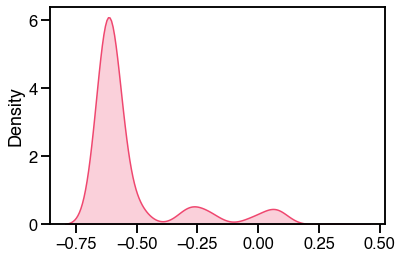

In [100]:
sns.kdeplot(global_mode_bootstrap2, fill=True)

In [23]:
save = False

if save:
    with open("./bootstrap_1000_results.pickle", "wb") as out:
        pickle.dump({
            'regression_for_cutoffs_bootstrap_full': regression_for_cutoffs_bootstrap_full,
            'df_reg_scores_bootstrap_full': df_reg_scores_bootstrap_full,
            'global_mode_bootstrap_full': global_mode_bootstrap_full,
            'alpha_q0_bootstrap_full': alpha_q0_bootstrap_full,
            'global_alpha_bootstrap': global_alpha_bootstrap,
            'global_mode_bootstrap2': global_mode_bootstrap2
        }, out)
else:
    with open("./bootstrap_1000_results.pickle", "rb") as f:
        bootstrap_full_pickles = pickle.load(f)
        regression_for_cutoffs_bootstrap_full = bootstrap_full_pickles["regression_for_cutoffs_bootstrap_full"]
        df_reg_scores_bootstrap_full = bootstrap_full_pickles["df_reg_scores_bootstrap_full"]
        global_mode_bootstrap_full = bootstrap_full_pickles["global_mode_bootstrap_full"]
        alpha_q0_bootstrap_full = bootstrap_full_pickles["alpha_q0_bootstrap_full"]
        global_alpha_bootstrap = bootstrap_full_pickles["global_alpha_bootstrap"]
        global_mode_bootstrap2 = bootstrap_full_pickles["global_mode_bootstrap2"]

/Users/shzh8108/research/clauset/faculty-hiring-misc/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/shzh8108/research/clauset/faculty-hiring-misc/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


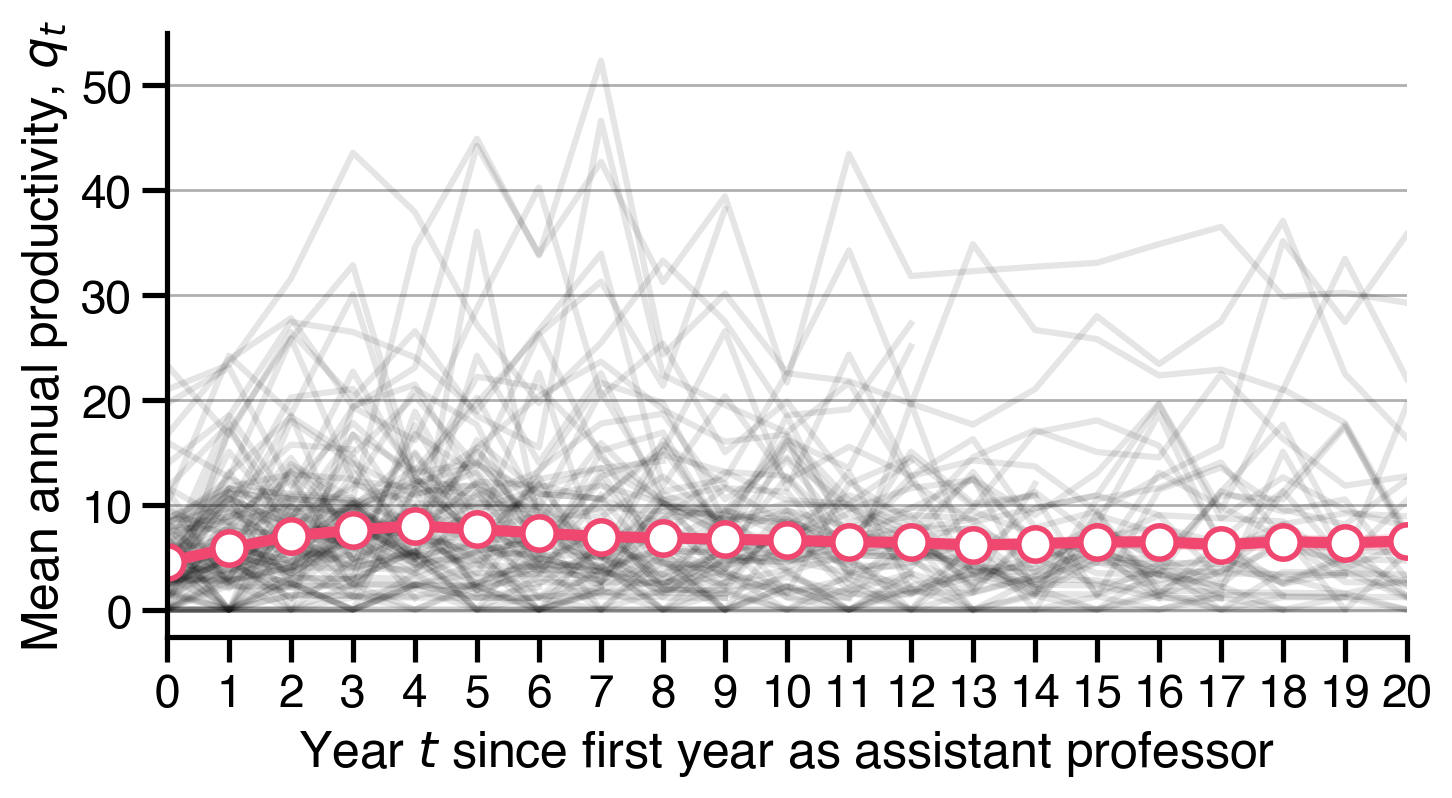

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=200)

np.random.seed(1)
random_dblp_ids = np.random.choice(list(set(df_prod_adj.dblp.values)), size=100, replace=False)
sampled_trajectories = df_prod_adj[df_prod_adj.dblp.isin(random_dblp_ids)]
sns.lineplot(sampled_trajectories.CareerAgeZero, sampled_trajectories.pubs_adj, units=sampled_trajectories.dblp, estimator=None, alpha=0.1, color='black', ax=ax)

sns.lineplot(df_prod_adj.CareerAgeZero, df_prod_adj.pubs_adj,ax=ax, lw=4, **marker_settings(colors[0], markersize=12))
ax.set_xlabel("Year $t$ since first year as assistant professor")
ax.set_ylabel("Mean annual productivity, $q_t$")
ax.set_xlim([0, 20])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_ticks(range(0, 21))
ax.yaxis.grid(linewidth=1)

sns.despine()

/Users/shzh8108/research/clauset/faculty-hiring-misc/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


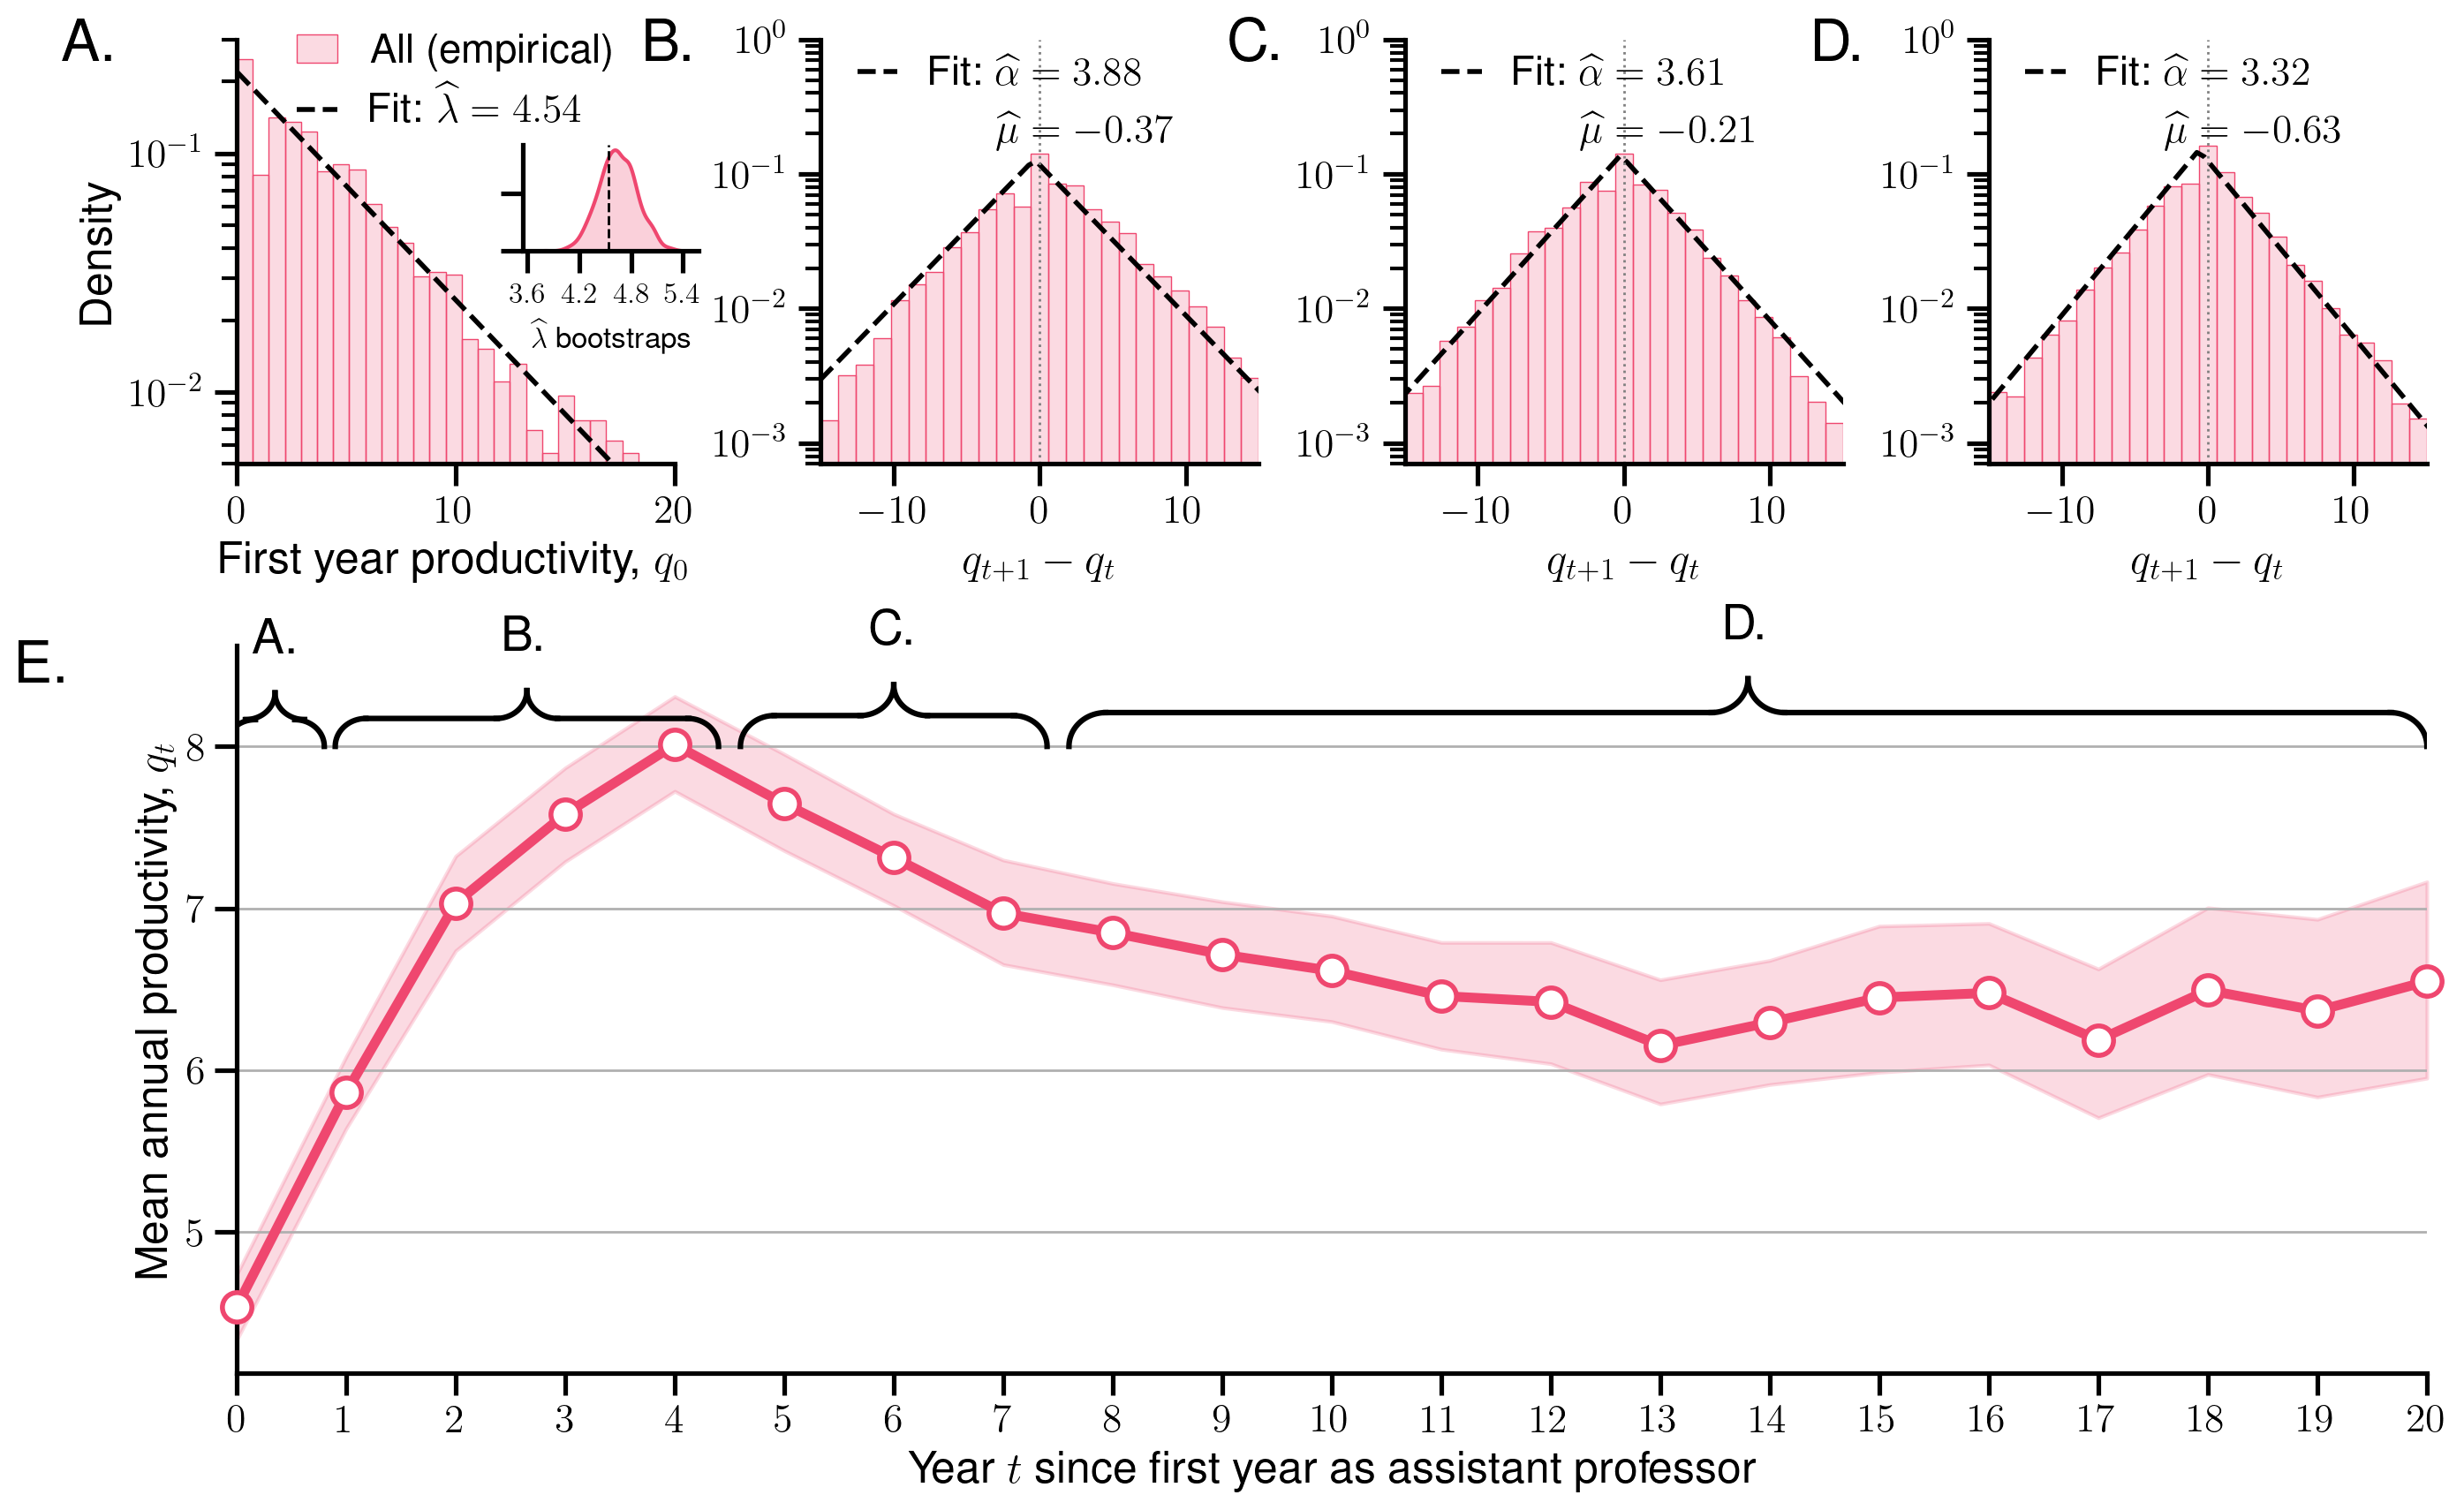

In [104]:
enable_matplotlib_latex()

fig, axes_dict = plt.subplot_mosaic("""
aabbccdd
aabbccdd
eeeeeeee
eeeeeeee
eeeeeeee
""", figsize=(16, 10), dpi=200)

bbox_to_anchor = (0, 0.95, 1, 0.1)
yrs_b = df_prod_adj[(df_prod_adj.CareerAgeZero > 0) & (df_prod_adj.CareerAgeZero <= 4)]
yrs_c = df_prod_adj[(df_prod_adj.CareerAgeZero > 4) & (df_prod_adj.CareerAgeZero <= 7)]
yrs_d = df_prod_adj[(df_prod_adj.CareerAgeZero > 7)]

fit_label = "\\text{{Fit:~}}"
handlelength = 1

ax = axes_dict['a']
ax.annotate("A.", (-0.4, 0.95), xycoords="axes fraction", fontsize=24)

first_years = df_prod_adj[df_prod_adj.CareerAgeZero == 0]

q0_lambda = first_years.pubs_adj.mean()
q0_rv = st.expon(loc=0, scale=q0_lambda)
x = np.linspace(0, 25, 100)

sns.histplot(first_years.pubs_adj, ax=ax, stat='density', label="All (empirical)", alpha=0.2, lw=0.5, edgecolor=colors[0])
#sns.kdeplot(first_years.pubs_adj, ax=ax, alpha=1, lw=4, clip=[0, 20], label="Empirical density")
ax.plot(x, q0_rv.pdf(x), lw=2, label=f'Fit: $\widehat{{\lambda}} = {q0_lambda:.2f}$', color='black', linestyle='--')
ax.set_xlim([0, 20])
ax.set_ylim([1e-3*5, .3])
ax.set_ylabel("Density")
ax.semilogy()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper center', frameon=False, bbox_to_anchor=(0, 1, 1, 0.1), handlelength=handlelength)
ax.set_xlabel("First year productivity, $q_0$")


axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.7, .55, .4, .25),
                   bbox_transform=ax.transAxes)
sns.kdeplot(alpha_q0_bootstrap_full, fill=True, ax=axins)
axins.tick_params(left=True, right=False, labelleft=False, labelright=False)
axins.set_xlabel("$\widehat{\lambda}$ bootstraps")
axins.xaxis.label.set_size(12)
axins.tick_params(axis='x', labelsize=12)
axins.set_ylabel(None)
axins.axvline(q0_lambda, linestyle='--', lw=1, color='black')
axins.xaxis.set_major_locator(MaxNLocator(4))



ax = axes_dict['b']
ax.annotate("B.", (-0.4, 0.95), xycoords="axes fraction", fontsize=24)

sns.histplot(yrs_b.q_adj_delta.dropna(), ax=ax, stat='density', binrange=(-15, 15), bins=25, lw=0.5, edgecolor=colors[0], alpha=0.2)
_, mle_alpha, mle_mode = plot_laplace_fit(ax, yrs_b.q_adj_delta.dropna(),fit_label, "black", linestyle="--", lw=2)
ax.legend(loc='upper left', frameon=False, bbox_to_anchor=bbox_to_anchor, handlelength=handlelength)

ax.set_xlabel("$q_{t+1} - q_t$")
ax.set_ylabel(None)
ax.set_xlim([-15, 15])
ax.set_ylim([1e-4 * 7, 1])
ax.axvline(0, linestyle=':', color='gray', lw=1)

ax = axes_dict['c']
ax.annotate("C.", (-0.4, 0.95), xycoords="axes fraction", fontsize=24)

sns.histplot(yrs_c.q_adj_delta.dropna(), ax=ax, stat='density', binrange=(-15, 15), bins=25, lw=0.5, edgecolor=colors[0], alpha=0.2)
_, mle_alpha, mle_mode = plot_laplace_fit(ax, yrs_c.q_adj_delta.dropna(), fit_label, "black", linestyle="--", lw=2)
ax.legend(loc='upper left', frameon=False, bbox_to_anchor=bbox_to_anchor, handlelength=handlelength)
ax.set_xlabel("$q_{t+1} - q_t$")
ax.set_ylabel(None)
ax.set_xlim([-15, 15])
ax.set_ylim([1e-4 * 7, 1])
ax.axvline(0, linestyle=':', color='gray', lw=1)

ax = axes_dict['d']
ax.annotate("D.", (-0.4, 0.95), xycoords="axes fraction", fontsize=24)

sns.histplot(yrs_d.q_adj_delta.dropna(), ax=ax, stat='density', binrange=(-15, 15), bins=25, lw=0.5, edgecolor=colors[0], alpha=0.2)
_, mle_alpha, mle_mode = plot_laplace_fit(ax, yrs_d.q_adj_delta.dropna(), fit_label, "black", linestyle="--", lw=2)
ax.legend(loc='upper left', frameon=False, bbox_to_anchor=bbox_to_anchor, handlelength=handlelength)
ax.set_xlabel("$q_{t+1} - q_t$")
ax.set_ylabel(None)
ax.set_xlim([-15, 15])
ax.set_ylim([1e-4 * 7, 1])
ax.axvline(0, linestyle=':', color='gray', lw=1)


ax = axes_dict['e']
ax.annotate("E.", (-0.1, 0.95), xycoords="axes fraction", fontsize=24)

sns.lineplot(df_prod_adj.CareerAgeZero, df_prod_adj.pubs_adj,ax=ax, lw=4, **marker_settings(colors[0], markersize=12))
ax.set_clip_on(False)
ax.set_xlabel("Year $t$ since first year as assistant professor")
ax.set_ylabel("Mean annual productivity, $q_t$")
ax.set_xlim([0, 20])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_ticks(range(0, 21))
ax.yaxis.grid(linewidth=1)
plt.setp(ax.collections, clip_on=False)
plt.setp(ax.lines, clip_on=False, zorder=5)

font = {'color': 'black', 'size': 20}
h = 8
gap = 0.1
curlyBrace(fig, ax, (-0.1, h), (0.8, h), str_text="A.", color='black', k_r=0.3, fontdict=font)
curlyBrace(fig, ax, (0.8 + gap, h), (4.5 - gap, h), str_text="B.", color='black', k_r=0.08, fontdict=font)
curlyBrace(fig, ax, (4.5 + gap, h), (7.5 - gap, h), str_text="C.", color='black', k_r=0.11, fontdict=font)
curlyBrace(fig, ax, (7.5 + gap, h), (20, h), str_text="D.", color='black', k_r=0.027, fontdict=font)
#curlyBrace(fig, ax, (14.5 + gap, h), (20, h), str_text="D.", color='black', k_r=0.05, fontdict=font)

plt.subplots_adjust(wspace=1, hspace=1.5)

sns.despine()
plt.savefig("./figures/canonical_trajectory_and_stages.pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)

disable_matplotlib_latex()

/Users/shzh8108/research/clauset/faculty-hiring-misc/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


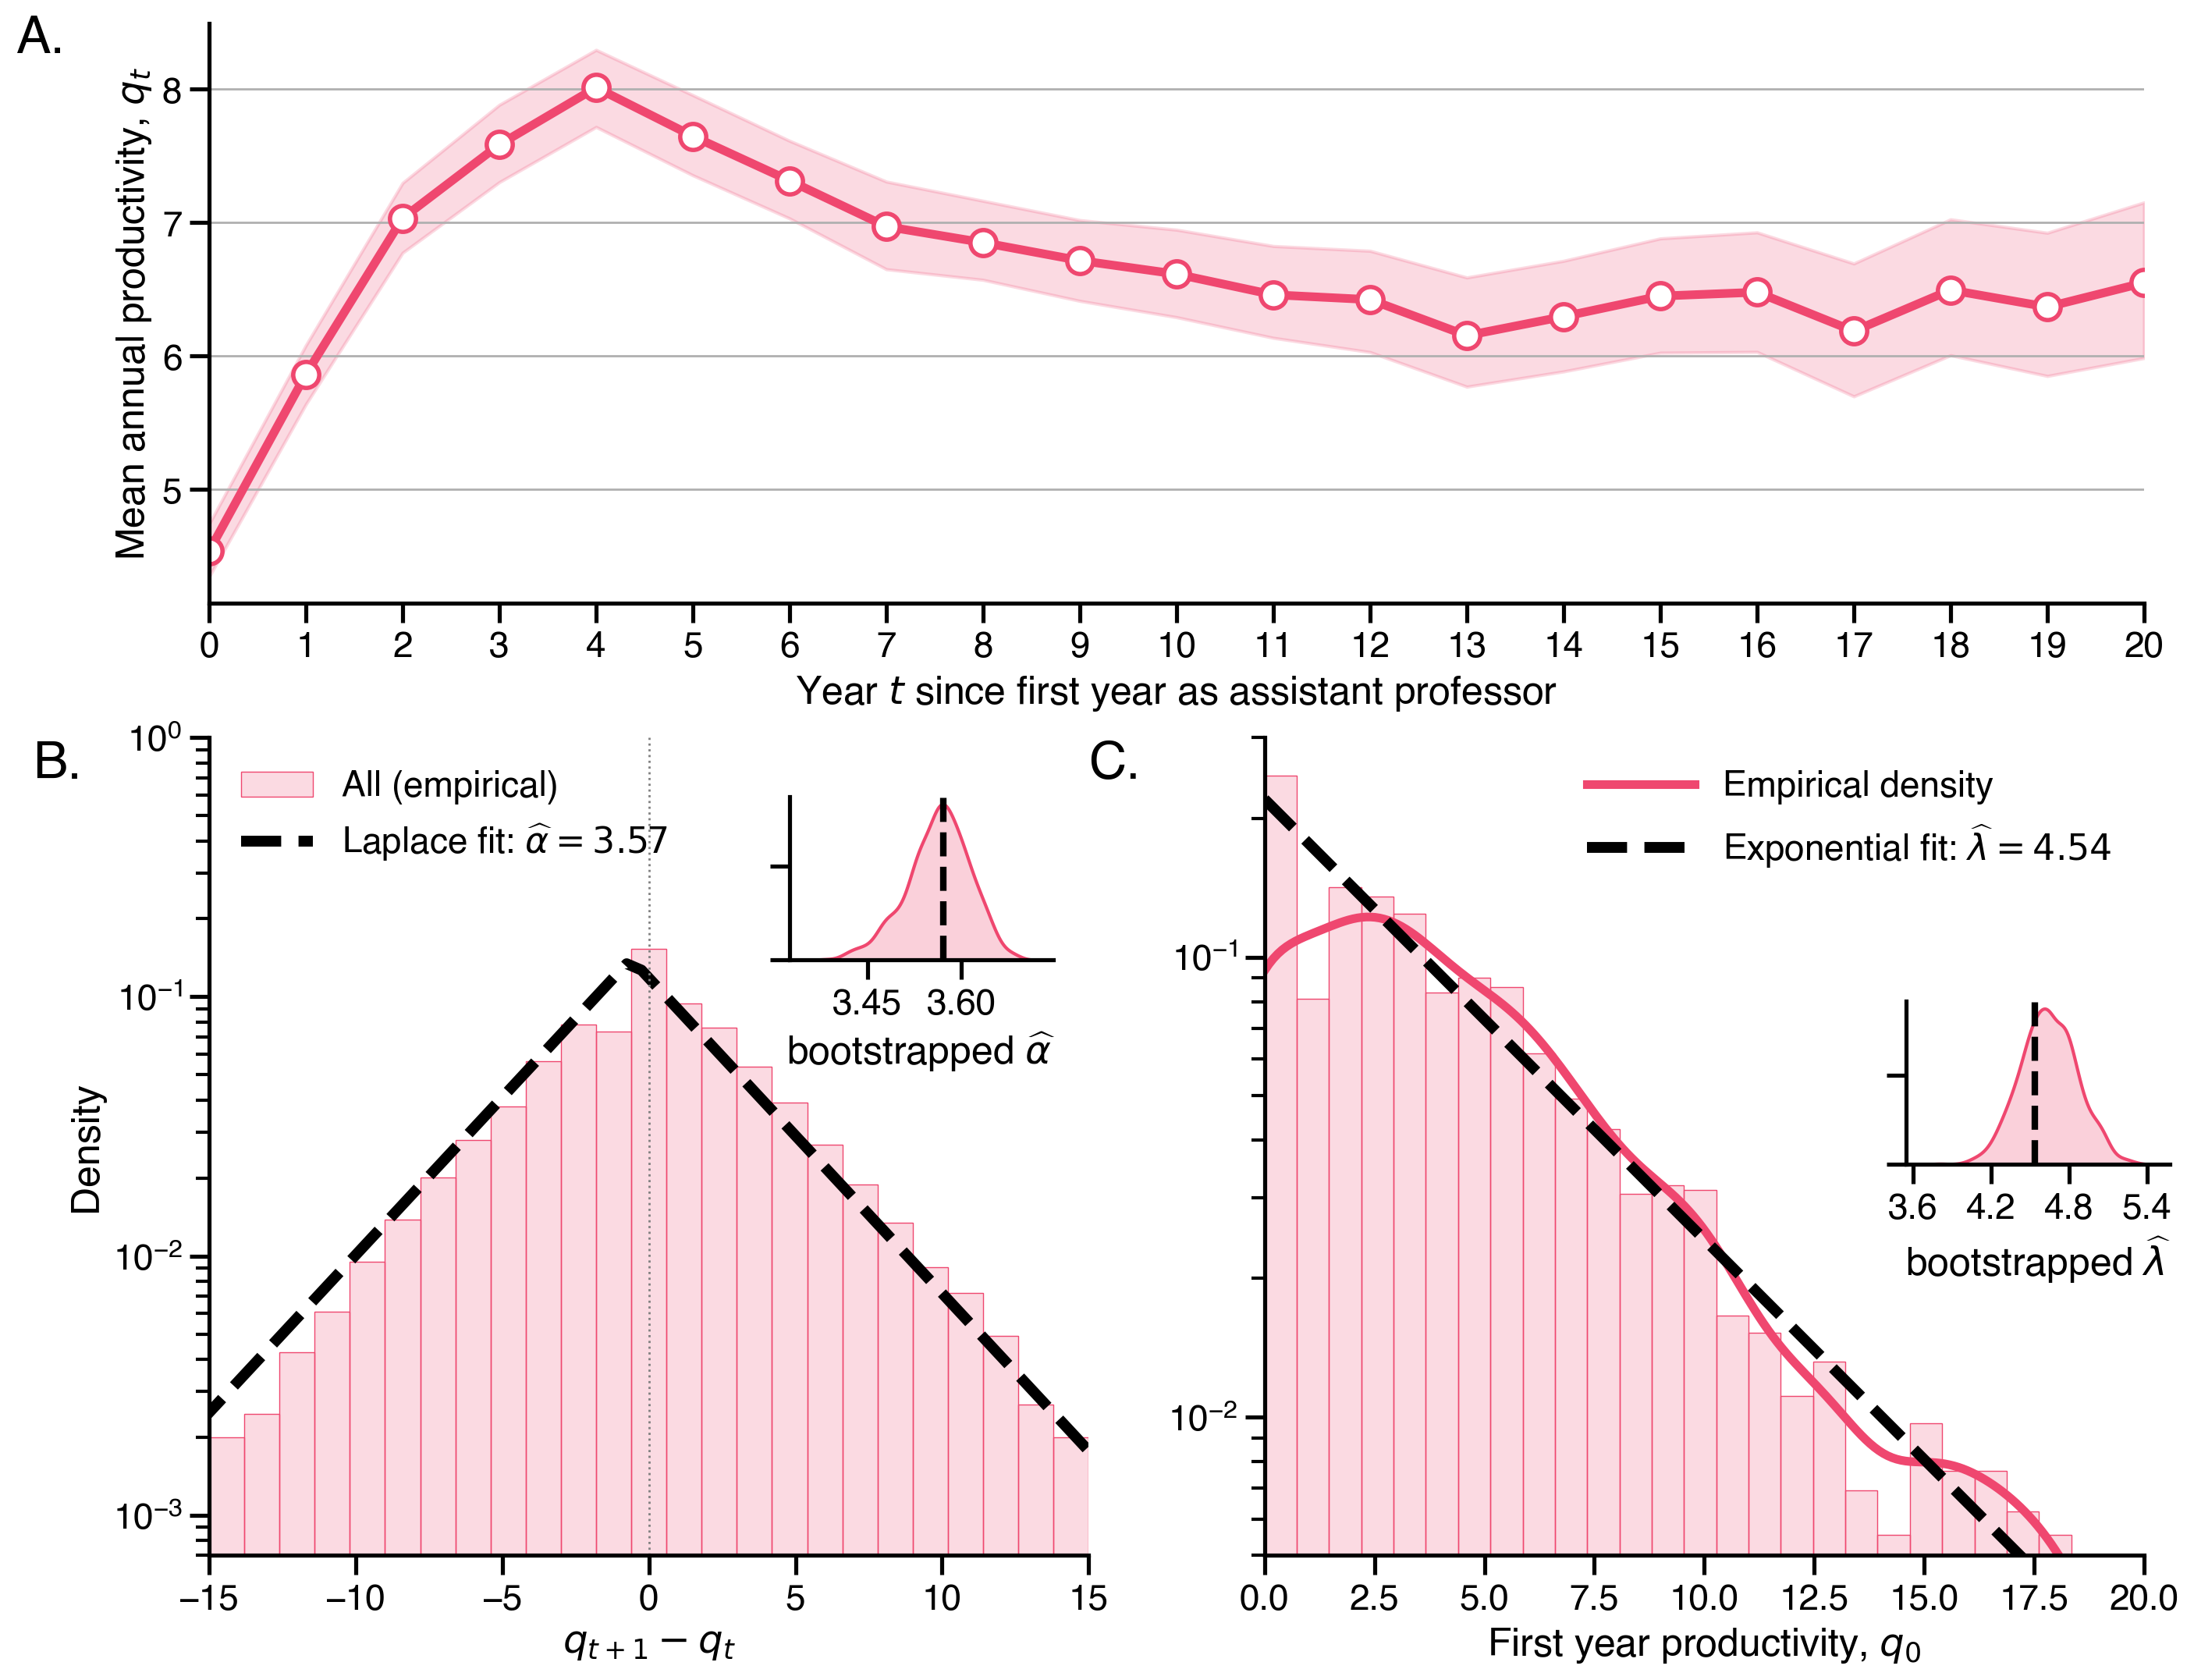

In [115]:
fig, axes_dict = plt.subplot_mosaic("""
aa
aa
aa
bc
bc
bc
bc
""", figsize=(16, 13), dpi=200)

ax = axes_dict['a']
ax.annotate("A.", (-0.1, 0.95), xycoords="axes fraction", fontsize=24)

sns.lineplot(df_prod_adj.CareerAgeZero, df_prod_adj.pubs_adj,ax=ax, lw=4, **marker_settings(colors[0], markersize=12))
ax.set_xlabel("Year $t$ since first year as assistant professor")
ax.set_ylabel("Mean annual productivity, $q_t$")
ax.set_xlim([0, 20])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_ticks(range(0, 21))
ax.yaxis.grid(linewidth=1)


ax = axes_dict['b']

sns.histplot(df_prod_adj.q_adj_delta.dropna(), ax=ax, stat='density', label="All (empirical)", binrange=(-15, 15), bins=25, lw=0.5, edgecolor=colors[0], alpha=0.2)
_, mle_alpha, mle_mode = plot_laplace_fit(ax, df_prod_adj.q_adj_delta.dropna(), "Laplace fit", "black", linestyle="--")

# reverse legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', frameon=False)

ax.set_xlabel("$q_{t+1} - q_t$")
ax.set_ylabel("Density")
ax.set_xlim([-15, 15])
ax.set_ylim([1e-4 * 7, 1])
ax.axvline(0, linestyle=':', color='gray', lw=1)
ax.annotate("B.", (-0.2, 0.95), xycoords="axes fraction", fontsize=24)

axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.68, .75, .3, .2),
                   bbox_transform=ax.transAxes)
sns.kdeplot(global_alpha_bootstrap, fill=True, ax=axins)
axins.tick_params(left=True, right=False, labelleft=False, labelright=False)
axins.set_xlabel("bootstrapped $\\widehat{\\alpha}$")
axins.set_ylabel(None)
axins.axvline(mle_alpha, linestyle='--', lw=3, color='black')
axins.xaxis.set_major_locator(MaxNLocator(4))


ax = axes_dict['c']
first_years = df_prod_adj[df_prod_adj.CareerAgeZero == 0]

q0_lambda = first_years.pubs_adj.mean()
q0_rv = st.expon(loc=0, scale=q0_lambda)
x = np.linspace(0, 25, 100)

sns.histplot(first_years.pubs_adj, ax=ax, stat='density', alpha=0.2, lw=0.5, edgecolor=colors[0])
sns.kdeplot(first_years.pubs_adj, ax=ax, alpha=1, lw=4, clip=[0, 20], label="Empirical density")
ax.plot(x, q0_rv.pdf(x), lw=5, label=f'Exponential fit: $\widehat{{\lambda}} = {q0_lambda:.2f}$', color='black', linestyle='--')
ax.set_xlim([0, 20])
ax.set_ylim([1e-3*5, .3])
ax.set_ylabel("")
ax.semilogy()
ax.legend(loc='upper right', frameon=False, handlelength=3)
ax.set_xlabel("First year productivity, $q_0$")
ax.annotate("C.", (-0.2, 0.95), xycoords="axes fraction", fontsize=24)

axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.75, .5, .3, .2),
                   bbox_transform=ax.transAxes)
sns.kdeplot(alpha_q0_bootstrap_full, fill=True, ax=axins)
axins.tick_params(left=True, right=False, labelleft=False, labelright=False)
axins.set_xlabel("bootstrapped $\widehat{\lambda}$")
axins.set_ylabel(None)
axins.axvline(q0_lambda, linestyle='--', lw=3, color='black')
axins.xaxis.set_major_locator(MaxNLocator(4))

plt.subplots_adjust(wspace=0.2, hspace=1.3)

sns.despine()
plt.savefig("./figures/model_criteria_square.pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)

In [640]:
df_reg_scores.sort_values(by='aic_varying')[['cutoffs', 'aic_varying', 'bic_varying']]

,cutoffs,aic_varying,bic_varying
499,"(4, 7, 13)",80758.052684,80750.211567
497,"(4, 7, 11)",80758.371078,80750.529961
498,"(4, 7, 12)",80758.799436,80750.958319
501,"(4, 7, 15)",80759.324970,80751.483853
496,"(4, 7, 10)",80759.420947,80751.579830
...,...,...,...
1157,"(18, 19)",80895.828765,80889.947927
1154,"(17, 18, 19)",80895.867890,80888.026773
171,"(1, 19)",80897.989196,80892.108358
0,"(1,)",80901.398044,80897.477485


In [105]:
mle_cutoffs = df_reg_scores.sort_values(by='aic_varying').cutoffs.iloc[0]
mle_cutoffs_fixed = df_reg_scores.sort_values(by='aic_fixed').cutoffs.iloc[0]
mle_cutoffs_full = df_reg_scores_full.sort_values(by='aic_varying').cutoffs.iloc[0]

mle_cutoffs, mle_cutoffs_fixed, mle_cutoffs_full

((4, 7, 13), (1, 5, 10), (4, 7, 11))

In [106]:
num_trajs = 3000
trajectories_reg_mle = simulate_trajectories_using_mode_regression(regression_for_cutoffs[mle_cutoffs], alpha_q0, num_trajs)
trajectories_reg_mle_fixed = simulate_trajectories_using_mode_regression(regression_for_cutoffs[mle_cutoffs_fixed], alpha_q0, num_trajs, global_mode=global_mode)
trajectories_reg_mle_full = simulate_trajectories_using_mode_regression(regression_for_cutoffs_full[mle_cutoffs_full], alpha_q0_full, num_trajs)

In [107]:
df_traj_reg_mle_sim = trajectories_to_dataframe(trajectories_reg_mle)
rfc_sim_recover, dfr_sim_recover, gm_sim_recover, aq0_sim_recover = score_cutoffs(df_traj_reg_mle_sim, top_cutoffs_50)
cutoffs_sim_recover = dfr_sim_recover.sort_values(by='aic_varying').cutoffs.iloc[0]
traj_sim_recover = simulate_trajectories_using_mode_regression(rfc_sim_recover[cutoffs_sim_recover], aq0_sim_recover, int(num_trajs/2))

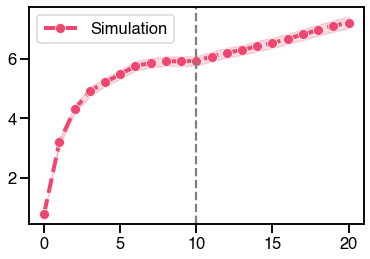

In [91]:
traj_sim_bend = simulate_trajectories_using_mode_regression([
    {'cutoffs': (10,), 'cutoff_start': 0, 'alpha': 3, 'mode_beta': 0.8},
    {'cutoffs': (10,), 'cutoff_start': 10, 'alpha': 1.1, 'mode_beta': 1},
], 0.8, num_trajs)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_trajectories(ax, traj_sim_bend)
ax.axvline(10, color='gray', linestyle='--')

In [645]:
traj_sim_swoop = simulate_trajectories_using_mode_regression([
    {'cutoffs': (15,), 'cutoff_start': 0, 'alpha': 5, 'mode_beta': 0.8},
    {'cutoffs': (15,), 'cutoff_start': 15, 'alpha': 3, 'mode_beta': 1.1},
], 10, num_trajs)

df_traj_sim_swoop = trajectories_to_dataframe(traj_sim_swoop)

start_time = time.time()
rfc_sim_swoop, dfr_sim_swoop, gm_sim_swoop, aq0_sim_swoop = score_cutoffs(df_traj_sim_swoop, all_cutoffs)
end_time = time.time()

cutoffs_sim_swoop = dfr_sim_swoop.sort_values(by='aic_varying').cutoffs.iloc[0]
traj_sim_swoop = simulate_trajectories_using_mode_regression(rfc_sim_swoop[cutoffs_sim_swoop], aq0_sim_swoop, num_trajs)

print(end_time - start_time)

103.32176685333252


In [647]:
traj_flat = np.random.normal(loc=5, scale=0.5, size=(21, 3000))

df_traj_sim_flat = trajectories_to_dataframe(traj_flat)
start_time = time.time()
rfc_sim_flat, dfr_sim_flat, gm_sim_flat, aq0_sim_flat = score_cutoffs(df_traj_sim_flat, all_cutoffs)
stop_time = time.time()
cutoffs_sim_flat = dfr_sim_flat.sort_values(by='aic_varying').cutoffs.iloc[0]
traj_sim_flat = simulate_trajectories_using_mode_regression(rfc_sim_flat[cutoffs_sim_flat], aq0_sim_flat, num_trajs)

In [648]:
N_emp = len(df_prod_adj)

/Users/shzh8108/research/clauset/faculty-hiring-misc/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/shzh8108/research/clauset/faculty-hiring-misc/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/shzh8108/research/clauset/faculty-hiring-misc/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing 

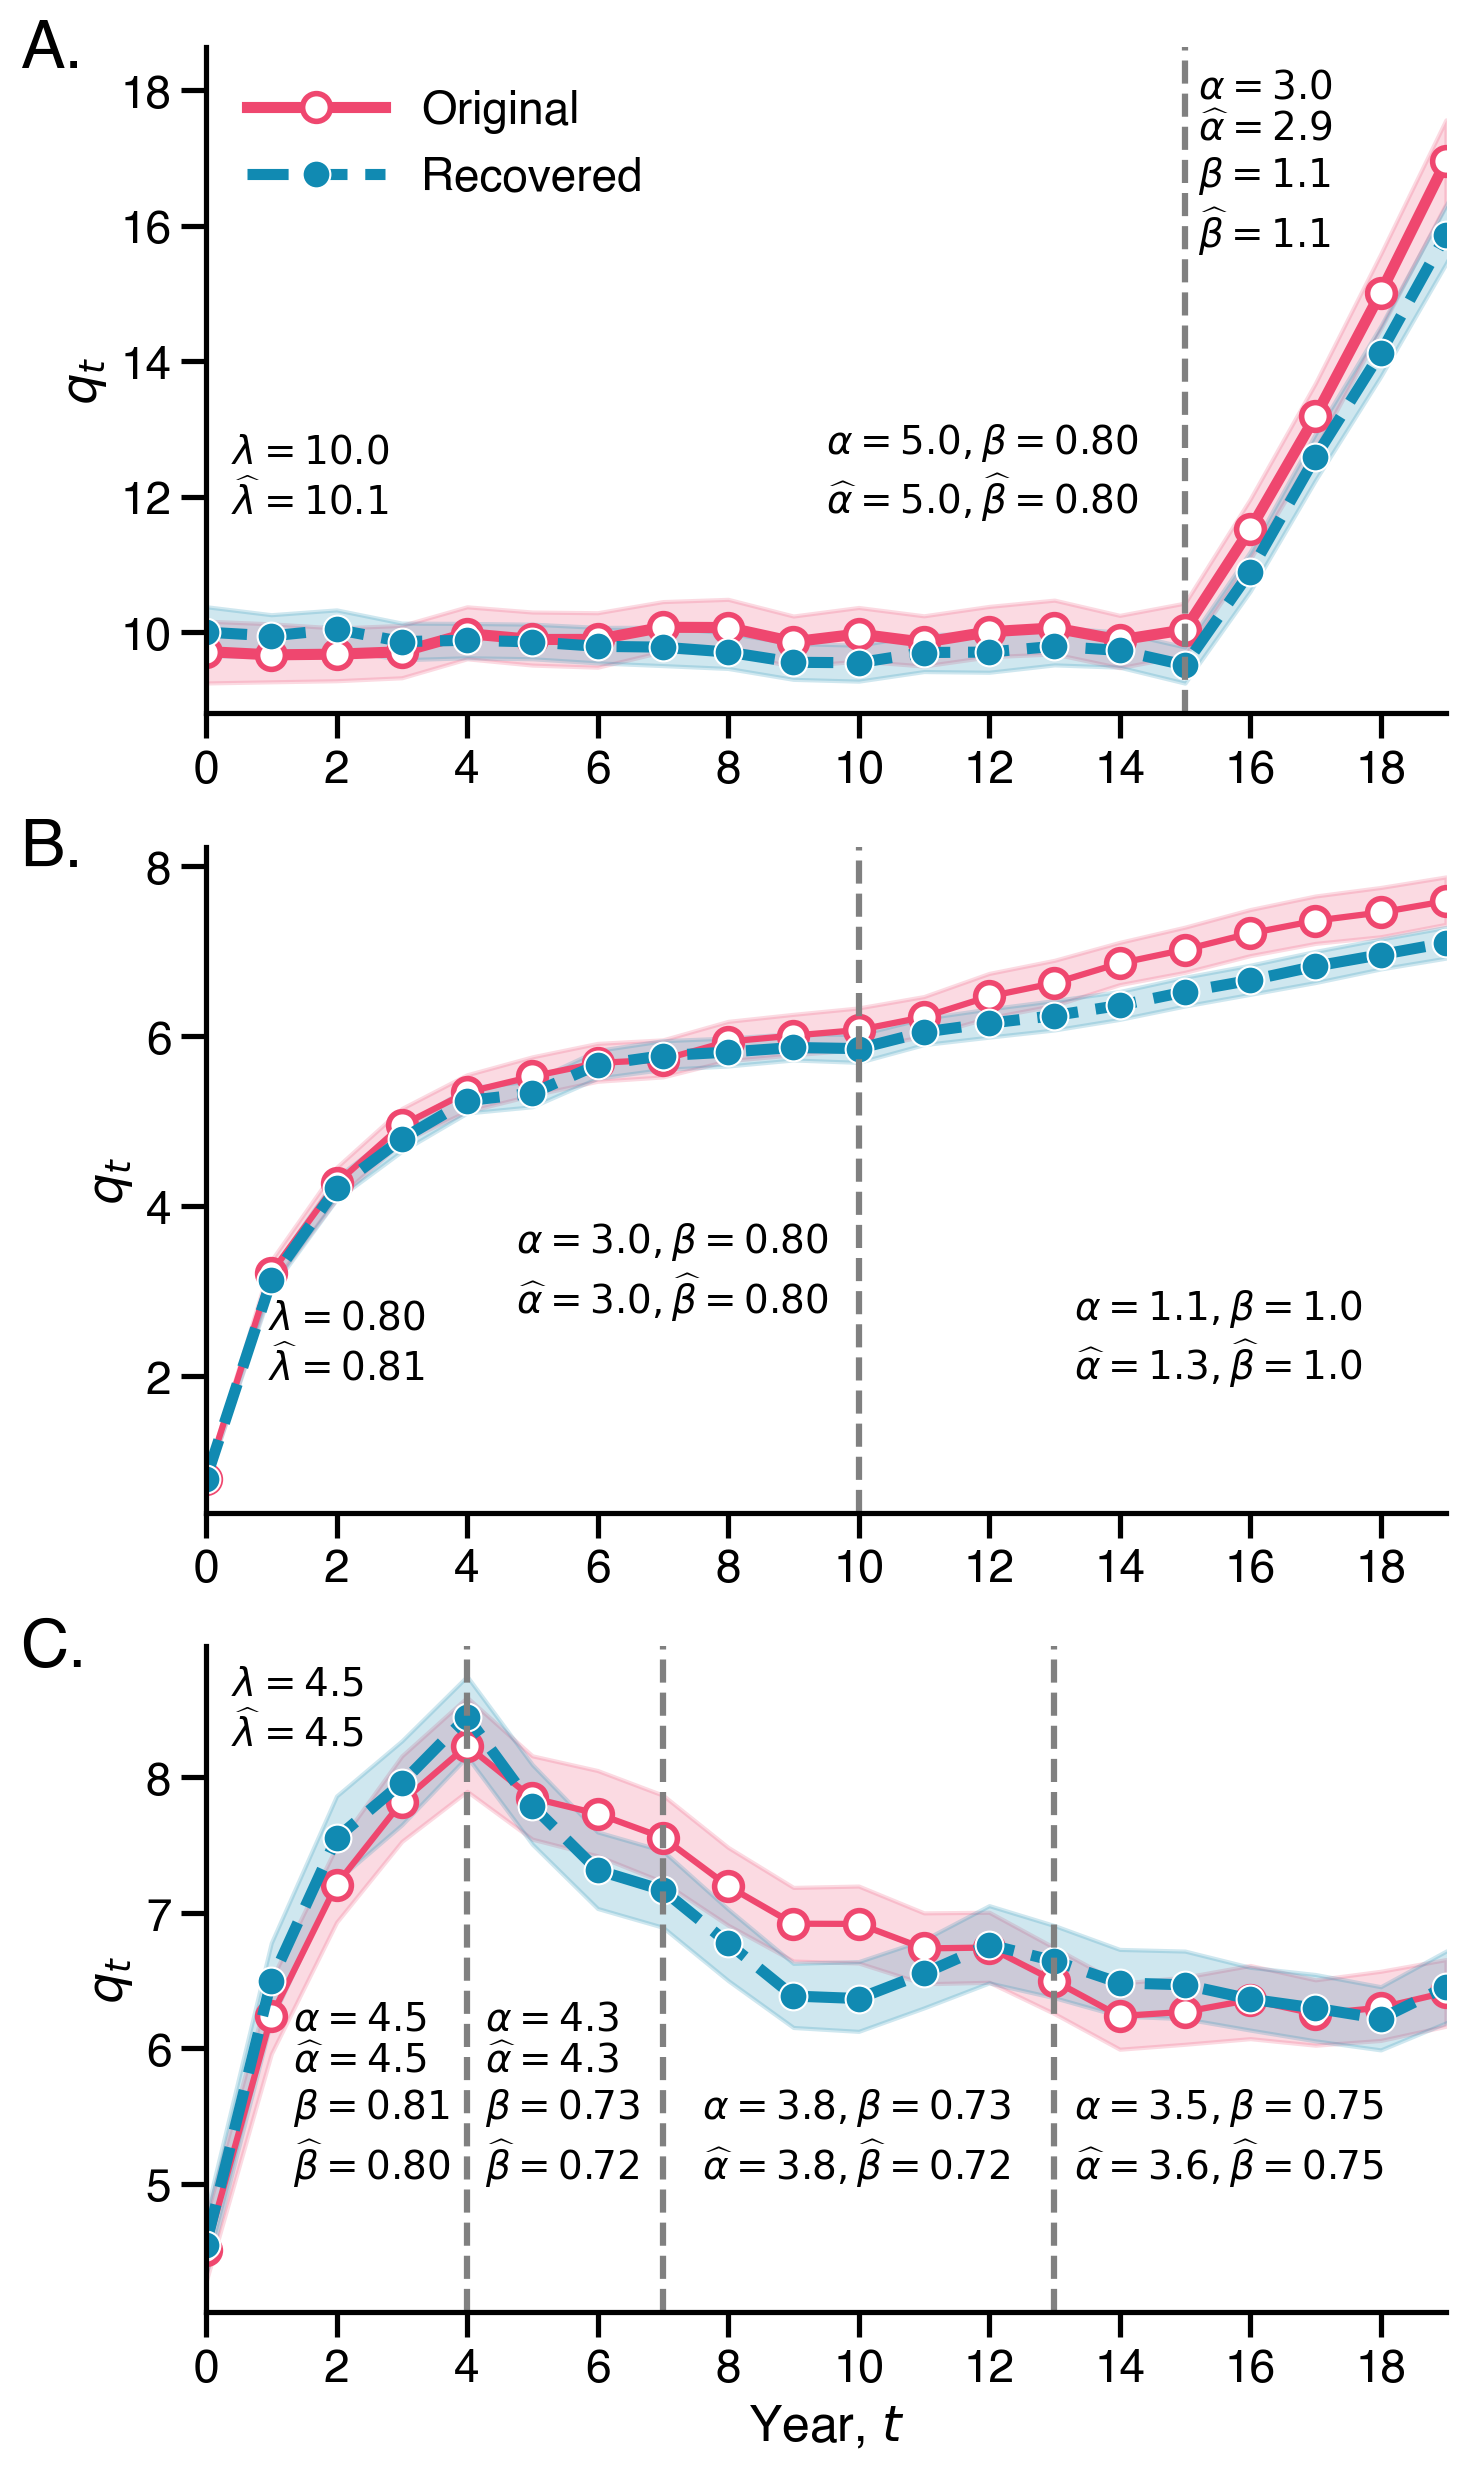

In [985]:
fig, axes = plt.subplots(3, 1, figsize=(8, 15), dpi=200)

ax = axes[0]
ax.annotate("A.", (-0.15, 0.97), xycoords="axes fraction", fontsize=24)

sns.lineplot(df_traj_sim_swoop.head(N_emp).CareerAgeZero.values, df_traj_sim_swoop.head(N_emp).pubs_adj.values, ax=ax, label='Original', estimator=np.mean, lw=4, **marker_settings(colors[0], markersize=10))
plot_trajectories(ax, traj_sim_swoop, label='Recovered', markersize=10)
plot_cutoffs(ax, cutoffs_sim_swoop, 'gray')

ax.set_xlabel(None)
ax.set_ylabel("$q_t$")
ax.annotate(r"""$\lambda = 10.0$
$\widehat{\lambda} = 10.1$""", (0.02, 0.3), xycoords="axes fraction", fontsize=14)

ax.annotate(r"""$\alpha = 5.0, \beta=0.80$
$\widehat{\alpha} = 5.0, \widehat{\beta}=0.80$""", (0.5, 0.3), xycoords="axes fraction", fontsize=14)

ax.annotate(r"""$\alpha = 3.0$
$\widehat{\alpha} = 2.9$
$\beta=1.1$
$\widehat{\beta}=1.1$""", (0.8, 0.7), xycoords="axes fraction", fontsize=14)

ax.set_xlim([0, 19])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(loc='upper left', frameon=False, handlelength=3)



ax = axes[1]
ax.annotate("B.", (-0.15, 0.97), xycoords="axes fraction", fontsize=24)

sns.lineplot(df_traj_sim_bend.head(N_emp).CareerAgeZero.values, df_traj_sim_bend.head(N_emp).pubs_adj.values, ax=ax, label='Original', estimator=np.mean, **marker_settings(colors[0]))
plot_trajectories(ax, traj_sim_bend, label='Recovered')
plot_cutoffs(ax, cutoffs_sim_bend, 'gray')

ax.set_xlabel(None)
ax.set_ylabel("$q_t$")

ax.set_xlim([0, 19])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.legend(loc='lower right', frameon=False, handlelength=1)

ax.annotate(r"""$\lambda = 0.80$
$\widehat{\lambda} = 0.81$""", (0.05, 0.2), xycoords="axes fraction", fontsize=14)

ax.annotate(r"""$\alpha = 3.0, \beta=0.80$
$\widehat{\alpha} = 3.0, \widehat{\beta}=0.80$""", (0.25, 0.3), xycoords="axes fraction", fontsize=14)

ax.annotate(r"""$\alpha = 1.1, \beta=1.0$
$\widehat{\alpha} = 1.3, \widehat{\beta}=1.0$""", (0.7, 0.2), xycoords="axes fraction", fontsize=14)

ax.get_legend().remove()

ax = axes[2]
ax.annotate("C.", (-0.15, 0.97), xycoords="axes fraction", fontsize=24)

sns.lineplot(df_traj_reg_mle_sim.head(N_emp).CareerAgeZero.values, df_traj_reg_mle_sim.head(N_emp).pubs_adj.values, ax=ax, label='Original', estimator=np.mean, **marker_settings(colors[0]))
plot_trajectories(ax, traj_sim_recover, label='Recovered')
plot_cutoffs(ax, cutoffs_sim_recover, 'gray')

ax.set_xlabel("Year, $t$")
ax.set_ylabel("$q_t$")

ax.set_xlim([0, 19])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.legend(loc='lower right', frameon=False, handlelength=1)

ax.get_legend().remove()

ax.annotate(r"""$\lambda = 4.5$
$\widehat{\lambda} = 4.5$""", (0.02, 0.85), xycoords="axes fraction", fontsize=14)

# Early assistant career stage
ax.annotate(r"""$\alpha = 4.5$
$\widehat{\alpha} = 4.5$
$\beta=0.81$
$\widehat{\beta}=0.80$""", (0.07, 0.2), xycoords="axes fraction", fontsize=14)

# Late assistant career stage
ax.annotate(r"""$\alpha = 4.3$
$\widehat{\alpha} = 4.3$
$\beta=0.73$
$\widehat{\beta}=0.72$""", (0.225, 0.2), xycoords="axes fraction", fontsize=14)

# Associate career stage
ax.annotate(r"""$\alpha = 3.8, \beta=0.73$
$\widehat{\alpha} = 3.8, \widehat{\beta}=0.72$""", (0.4, 0.2), xycoords="axes fraction", fontsize=14)

# Full career stage
ax.annotate(r"""$\alpha = 3.5, \beta=0.75$
$\widehat{\alpha} = 3.6, \widehat{\beta}=0.75$""", (0.7, 0.2), xycoords="axes fraction", fontsize=14)

sns.despine()

plt.savefig("./figures/model_recovers_simulations.pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)

In [93]:
def print_pval(pval):
    if pval < 0.001:
        return 'p<0.001'
    if pval < 0.01:
        return f"p={pval:.03f}"
    
    return f"p={pval:.02f}"

/Users/shzh8108/research/clauset/faculty-hiring-misc/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


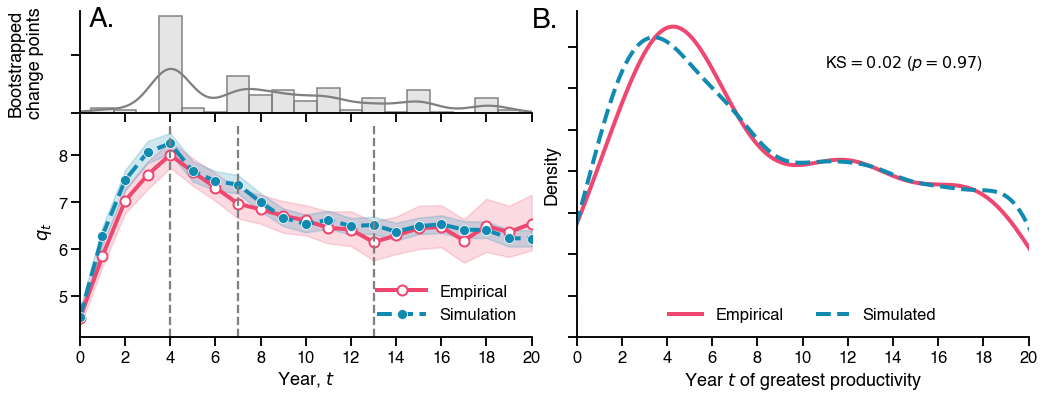

In [94]:
fig, axes_dict = plt.subplot_mosaic("""
ac
bc
bc
""", figsize=(17, 6))

ax=axes_dict['a']

sns.histplot(list(itertools.chain(*top_cutoff_1_bootstrap_full)), ax=ax, stat='density', discrete=True, binrange=(0,20), color="gray", edgecolor="gray", alpha=0.2)
sns.kdeplot(list(itertools.chain(*top_cutoff_1_bootstrap_full)), ax=ax, color="gray")

ax.set_xlim([0, 20])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

ax.set_ylabel("Bootstrapped\nchange points\n")
ax.annotate("A.", (0.02, 0.85), xycoords="axes fraction", fontsize=28)

ax=axes_dict['b']
sns.lineplot(df_prod_adj.CareerAgeZero, df_prod_adj.pubs_adj, label='Empirical', ax=ax, lw=4, **marker_settings(colors[0]))
plot_trajectories(ax, trajectories_reg_mle)

ax.set_xlabel("Year, $t$")
ax.set_ylabel("$q_t$")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim([0, 20])
plot_cutoffs(ax, mle_cutoffs, 'gray')
ax.legend(frameon=False, loc='lower right', handlelength=3)
#ax.get_legend().remove()

ax = axes_dict['c']
ax.annotate("B.", (-0.1, 0.95), xycoords="axes fraction", fontsize=28)

sns.kdeplot(df_prod_survivors.sort_values(by='pubs_adj', ascending=False).drop_duplicates('dblp_id').CareerAgeZero, label='Empirical', ax=ax, lw=4)
sns.kdeplot(np.argmax(trajectories_reg_mle, axis=0), label='Simulated', ax=ax, linestyle='--', lw=4)

ax.set_xlabel("Year $t$ of greatest productivity")
ax.set_ylabel("Density")
ax.yaxis.set_ticklabels([])
ax.set_xlim([0, 20])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.legend(frameon=False, ncol=2, loc='lower center')

ks_test_peak_year = st.ks_2samp(
    df_prod_survivors[df_prod_survivors.index == df_prod_survivors.groupby('dblp_id').pubs_adj.transform('idxmax')].CareerAgeZero,
    [traj.argmax() for traj in trajectories_reg_mle.T]
)

ax.text(11, 0.065, f"KS$={ks_test_peak_year.statistic:.2f}$ (${print_pval(ks_test_peak_year.pvalue)}$)", fontsize=16)

sns.despine()
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.savefig("./figures/model_fit.pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)

/Users/shzh8108/research/clauset/faculty-hiring-misc/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


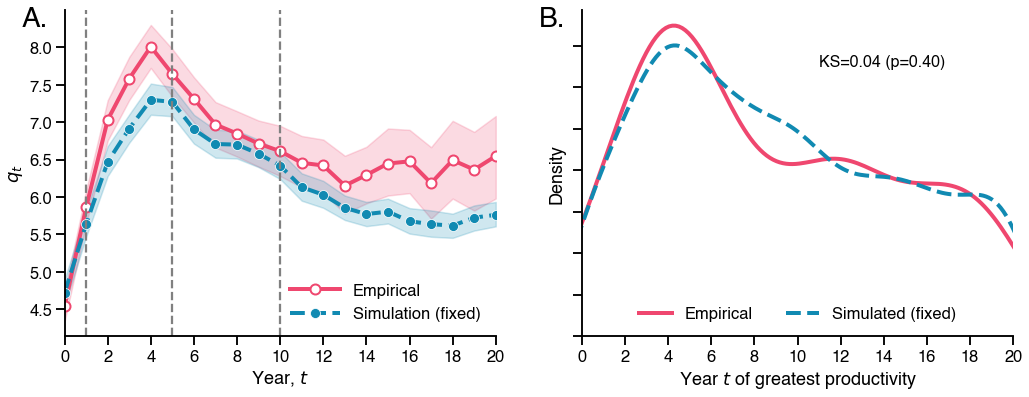

In [1287]:
fig, axes = plt.subplots(1, 2, figsize=(17, 6))

ax=axes[0]
ax.annotate("A.", (-0.1, 0.95), xycoords="axes fraction", fontsize=28)

sns.lineplot(df_prod_adj.CareerAgeZero, df_prod_adj.pubs_adj, label='Empirical', ax=ax, lw=4, **marker_settings(colors[0]))
plot_trajectories(ax, trajectories_reg_mle_fixed, "Simulation (fixed)")

ax.set_xlabel("Year, $t$")
ax.set_ylabel("$q_t$")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim([0, 20])
plot_cutoffs(ax, mle_cutoffs_fixed, 'gray')
ax.legend(frameon=False, loc='lower right', handlelength=3)


ax = axes[1]
ax.annotate("B.", (-0.1, 0.95), xycoords="axes fraction", fontsize=28)

sns.kdeplot(df_prod_survivors.sort_values(by='pubs_adj', ascending=False).drop_duplicates('dblp_id').CareerAgeZero, label='Empirical', ax=ax, lw=4)
sns.kdeplot(np.argmax(trajectories_reg_mle_fixed, axis=0), label='Simulated (fixed)', ax=ax, linestyle='--', lw=4)

ax.set_xlabel("Year $t$ of greatest productivity")
ax.set_ylabel("Density")
ax.yaxis.set_ticklabels([])
ax.set_xlim([0, 20])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.legend(frameon=False, ncol=2, loc='lower center')

ks_test_peak_year_fixed = st.ks_2samp(
    df_prod_survivors[df_prod_survivors.index == df_prod_survivors.groupby('dblp_id').pubs_adj.transform('idxmax')].CareerAgeZero,
    [traj.argmax() for traj in trajectories_reg_mle_fixed.T]
)

ax.text(11, 0.065, f"KS={ks_test_peak_year_fixed.statistic:.2f} (p={ks_test_peak_year_fixed.pvalue:.2f})", fontsize=16)

sns.despine()

In [1288]:
ks_test_within_career_sds = st.ks_2samp(
    df_prod_survivors.groupby('dblp_id').pubs_adj.std(),
    trajectories_reg_mle.std(axis=0)
)

ks_test_within_career_sds

KstestResult(statistic=0.13594117647058823, pvalue=1.732774184137753e-07)

In [291]:
(trajectories == 0).sum() / (trajectories.shape[0]*trajectories.shape[1])

0.12285238095238095

In [292]:
(np.floor(trajectories_emp) == 0).sum() / (trajectories_emp.shape[0] * trajectories.shape[1])

0.08604761904761905

In [1289]:
def wald_interval_95(p, n):
    err = np.sqrt(p * (1 - p) / n)
    return (p - 1.96 * err, p + 1.96 * err)
    


print(f"Simulations: p={p_sim:.3f} ({ci_sim[0]:.3f}, {ci_sim[1]:.3f})")
print(f"Empirical  : p={p_emp:.3f} ({ci_emp[0]:.3f}, {ci_emp[1]:.3f})")

Simulations: p=0.086 (0.083, 0.088)
Empirical  : p=0.159 (0.152, 0.165)


In [402]:
sum(df_prod_survivors.pubs == 0) /len(df_prod_survivors)

0.15870947965361332

In [395]:
st.ttest_ind(rounded_sim.flatten() == 0, np.floor(df_prod_survivors.pubs_adj) == 0, equal_var=False)

In [730]:
df_traj_reg_mle = trajectories_to_dataframe(trajectories_reg_mle)

In [1290]:
empirical_zero_run_lengths = list(chain(*df_prod_adj.groupby('dblp_id').pubs_adj.apply(count_zero_runs)))
hazard_counts_emp, hazard_emp, hazard_emp_vars = hazard_from_runlengths(empirical_zero_run_lengths)

empirical_zero_run_lengths_full = list(chain(*df_prod_survivors.groupby('dblp_id').pubs_adj.apply(count_zero_runs)))
hazard_counts_emp_full, hazard_emp_full, hazard_emp_vars_full = hazard_from_runlengths(empirical_zero_run_lengths_full)

In [1291]:
print(f"Empirical marginal: {sum([x['Y'] for x in hazard_counts_emp.values()]) / sum([x['N'] + x['Y'] for x in hazard_counts_emp.values()])}")
print(f"Empirical marginal (full): {sum([x['Y'] for x in hazard_counts_emp_full.values()]) / sum([x['N'] + x['Y'] for x in hazard_counts_emp_full.values()])}")

Empirical marginal: 0.36304286119784274
Empirical marginal (full): 0.35911230665770005


In [117]:
lighter_colors = ["#FFACBB", "#33ACD4"]

sns.color_palette(colors + lighter_colors)

[(0.9372549019607843, 0.2784313725490196, 0.43529411764705883),
 (0.06666666666666667, 0.5411764705882353, 0.6980392156862745),
 (0.023529411764705882, 0.8392156862745098, 0.6274509803921569),
 (0.027450980392156862, 0.23137254901960785, 0.2980392156862745),
 (1.0, 0.8196078431372549, 0.4),
 (1.0, 0.6745098039215687, 0.7333333333333333),
 (0.2, 0.6745098039215687, 0.8313725490196079)]

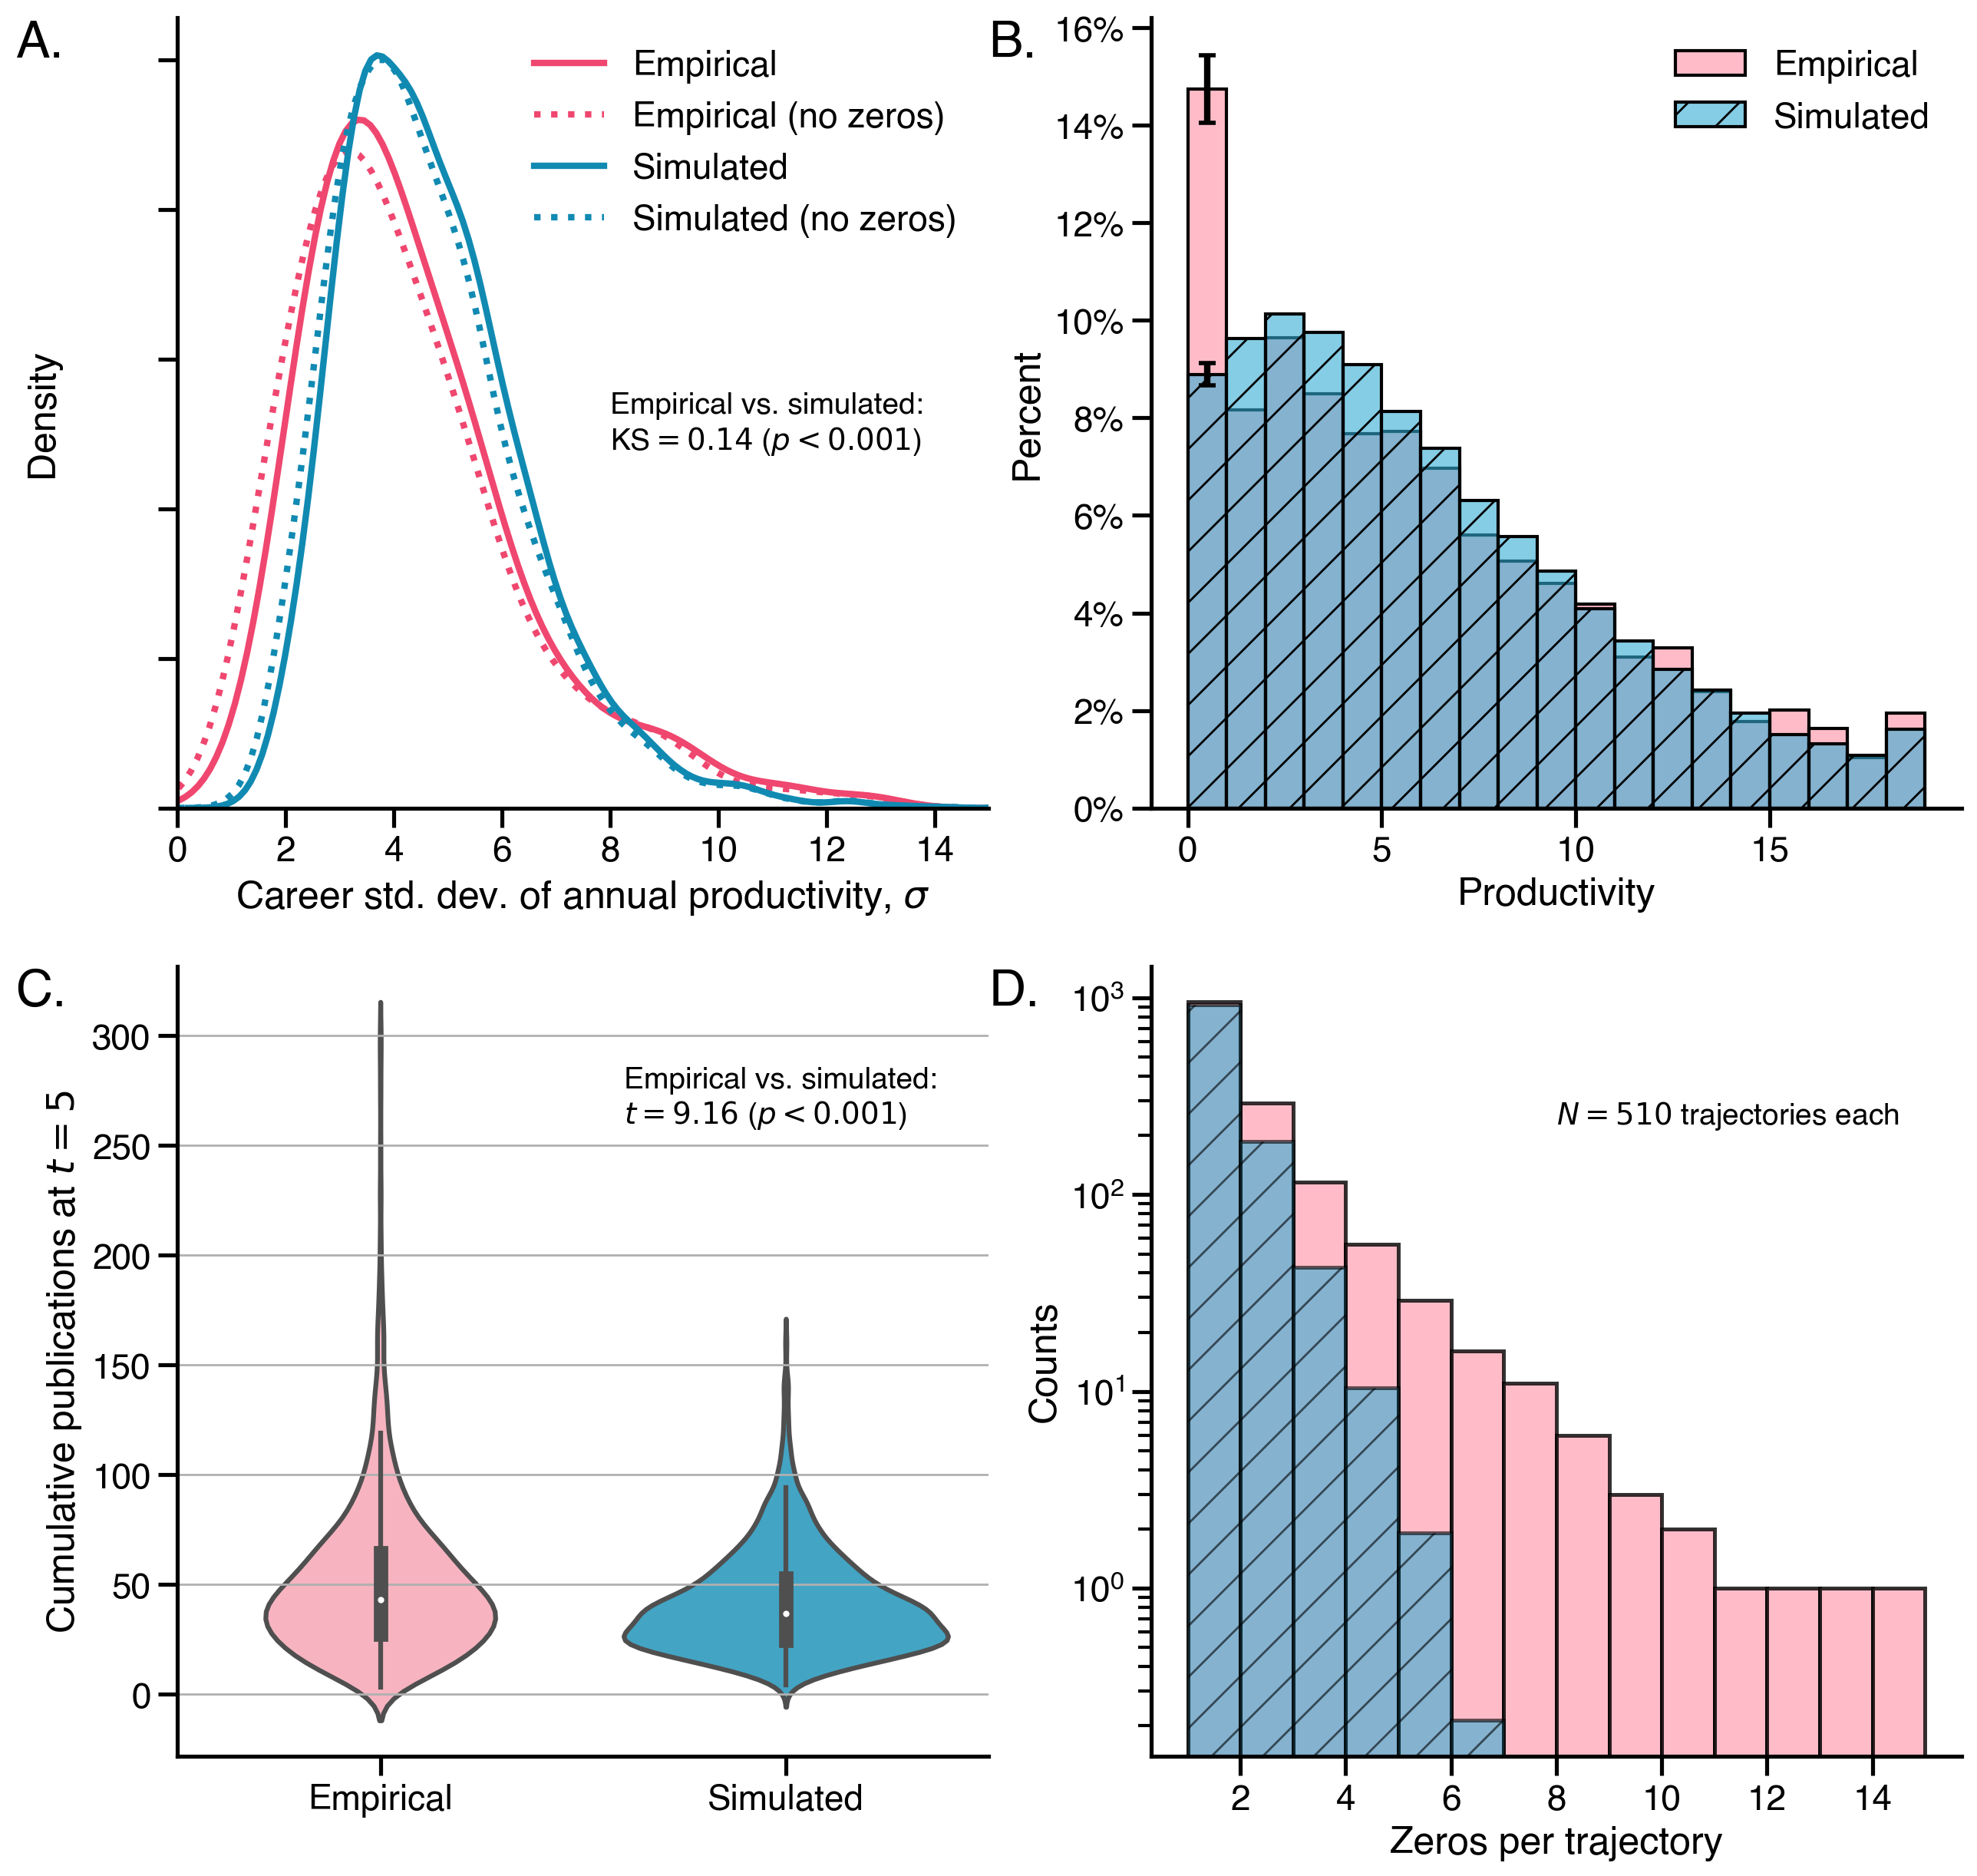

In [1300]:
# diagnostic_figures_2 (without b) no longer exists :)

def diagnostic_figures_2b(trajs):
    hatch = '/'
    ks_test = st.ks_2samp(
        df_prod_survivors.groupby('dblp_id').pubs_adj.std(),
        trajs.std(axis=0)
    )
    
    df_trajs = trajectories_to_dataframe(trajs)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 15), dpi=200)
    
    zero_run_lengths = list(chain(*[count_zero_runs(t) for t in np.floor(trajs.T)]))
    hazard_counts_sim, hazard_sim, hazard_sim_vars = hazard_from_runlengths(zero_run_lengths)

    df_year_5 = pd.DataFrame([
        df_prod_adj[df_prod_adj.CareerAge == 5].cumpubs.values,
        np.cumsum(trajs, axis=0)[5,:df_prod_adj[df_prod_adj.CareerAge == 5].shape[0]]
    ]).T

    df_year_5.columns = ['Empirical', 'Simulated']

    ax = axes[0][0]
    ax.annotate("A.", (-0.2, 0.95), xycoords="axes fraction", fontsize=24)

    lw = 3
    sns.kdeplot(df_prod_survivors.groupby('dblp_id').pubs_adj.std(), label='Empirical', ax=ax, color=colors[0], lw=lw)
    sns.kdeplot(df_prod_survivors[np.floor(df_prod_survivors.pubs_adj) > 0].groupby('dblp_id').pubs_adj.std(), label='Empirical (no zeros)', ax=ax, color=colors[0], linestyle=':', lw=lw)
    sns.kdeplot(df_trajs.groupby('ix').pubs_adj.std(), label='Simulated', ax=ax, color=colors[1], lw=lw)
    sns.kdeplot(df_trajs[np.floor(df_traj_reg_mle.pubs_adj) > 0].groupby('ix').pubs_adj.std(), label='Simulated (no zeros)', ax=ax, color=colors[1], linestyle=":", lw=lw)
    ax.set_xlim([0, 15])
    
    ax.set_xlabel("Career std. dev. of annual productivity, $\sigma$")
    ax.yaxis.set_ticklabels([])
    ax.set_ylabel("Density\n\n")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.legend(frameon=False, loc='upper right')
    ax.text(8, 0.12, f"Empirical vs. simulated:\nKS$={ks_test.statistic:.2f}$ (${print_pval(ks_test.pvalue)}$)", fontsize=14)


    
    ax = axes[0][1]
    ax.annotate("B.", (-0.2, 0.95), xycoords="axes fraction", fontsize=24)
    
    rounded_sim = np.floor(trajs[np.where(trajs <= 20)])
    p_sim = sum(rounded_sim.flatten() == 0) / len(rounded_sim.flatten())
    n_sim = len(rounded_sim.flatten())
    ci_sim = wald_interval_95(p_sim, n_sim)
    
    rounded_emp = np.floor(df_prod_survivors[df_prod_survivors.pubs_adj <= 20].pubs_adj)
    p_emp = sum(rounded_emp == 0) / len(rounded_emp)
    n_emp = len(rounded_emp)
    ci_emp = wald_interval_95(p_emp, n_emp)

    sns.histplot(rounded_emp, label='Empirical', stat="probability", color=lighter_colors[0], binwidth=1, alpha=0.8, linewidth=1.5, ax=ax)
    sns.histplot(rounded_sim, label='Simulated', stat="probability", color=lighter_colors[1], binwidth=1, alpha=0.6, linewidth=1.5, ax=ax, hatch=hatch)
    
    ax.errorbar(x=0.5, y=p_emp, yerr=ci_emp[1] - p_emp, color="black", capsize=4, elinewidth=3, capthick=2)
    ax.errorbar(x=0.5, y=p_sim, yerr=ci_sim[1] - p_sim, color="black", capsize=4, elinewidth=3, capthick=2)

    ax.legend(frameon=False)
    ax.set_xlabel("Productivity")
    ax.set_ylabel("Percent")
    ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

    
    
    
    ax = axes[1][0]
    ax.annotate("C.", (-0.2, 0.95), xycoords="axes fraction", fontsize=24)
    ttest_year_5 = st.ttest_ind(df_year_5.Empirical, df_year_5.Simulated, equal_var=False)
    yname = 'Cumulative publications at $t=5$'
    sns.violinplot(x='x', y=yname, data=df_year_5.melt(value_name=yname, var_name='x'), ax=ax, saturation=0.8, palette=lighter_colors)
    ax.set_xlabel(None)
    ax.text(0.6, 260, f"Empirical vs. simulated:\n$t={ttest_year_5.statistic:.2f}$ (${print_pval(ttest_year_5.pvalue)}$)", fontsize=14)
    ax.yaxis.grid(linewidth=1)

    
    
    
    ax = axes[1][1]
    ax.annotate("D.", (-0.2, 0.95), xycoords="axes fraction", fontsize=24)
    ax.bar(
        range(1, 15),
        [hazard_counts_emp_full[i]['N'] + hazard_counts_emp_full[i]['Y'] for i in range(1, 15)],
        align='edge', label='Empirical', color=lighter_colors[0], linewidth=1.8, alpha=0.8, edgecolor='black', width=1,
    )

    ax.bar(
        range(1, 15),
        [640/3000 * (hazard_counts_sim[i]['N'] + hazard_counts_sim[i]['Y']) for i in range(1, 15)],
        align='edge', label='Simulated', hatch=hatch, color=lighter_colors[1], linewidth=1.8, alpha=0.6, edgecolor='black', width=1
    )

    ax.semilogy()
    ax.set_xlabel("Zeros per trajectory")
    ax.set_ylabel("Counts")
    ax.annotate(f"$N={df_prod_survivors.dblp.nunique()}$ trajectories each", (0.5, 0.8), xycoords="axes fraction", fontsize=14)

    sns.despine()
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    sns.despine()

diagnostic_figures_2b(trajectories_reg_mle)
plt.savefig("./figures/model_unfit.pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)

In [111]:
df_prod_survivors.head()

,contribs,contribs_with_corr,current,dblp,department,facultyName,first_asst_job_rank,first_asst_job_year,has_postdoc,is_female,num_asst_jobs,phd_rank,phd_year,place,pubs,pubs_adj,pubs_with_corr,pubs_with_corr_adj,recordDate,year,CareerAge,dblp_id,pubs_adj_round,pubs_adj_next_round,pubs_adj_next,pubs_adj_next2,q_adj_delta,q_adj_delta2,q_delta_round_match,cumpubs,YearSinceDegree,CareerAgeZero
61,2.0,2.0,Full Professor,=Ouml=zsu:M=_Tamer,Computer Science,M. Tamer Ozsu,86.24,1984,False,False,1,42.17,1983.0,University of Waterloo,2,7.200019,2,7.200019,11/7/2011,1985,1,=Ouml=zsu:M=_Tamer1983.0,7.0,3.0,3.406681,3.229064,-3.793339,-0.177617,-4.0,16.381169,2.0,0
62,0.5,0.5,Full Professor,=Ouml=zsu:M=_Tamer,Computer Science,M. Tamer Ozsu,86.24,1984,False,False,1,42.17,1983.0,University of Waterloo,1,3.406681,1,3.406681,11/7/2011,1986,2,=Ouml=zsu:M=_Tamer1983.0,3.0,3.0,3.229064,0.000000,-0.177617,-3.229064,0.0,19.787850,3.0,1
63,0.5,0.5,Full Professor,=Ouml=zsu:M=_Tamer,Computer Science,M. Tamer Ozsu,86.24,1984,False,False,1,42.17,1983.0,University of Waterloo,1,3.229064,1,3.229064,11/7/2011,1987,3,=Ouml=zsu:M=_Tamer1983.0,3.0,0.0,0.000000,2.914364,-3.229064,2.914364,-3.0,23.016914,4.0,2
64,0.0,0.0,Full Professor,=Ouml=zsu:M=_Tamer,Computer Science,M. Tamer Ozsu,86.24,1984,False,False,1,42.17,1983.0,University of Waterloo,0,0.000000,0,0.000000,11/7/2011,1988,4,=Ouml=zsu:M=_Tamer1983.0,0.0,3.0,2.914364,13.872618,2.914364,10.958253,3.0,23.016914,5.0,3
65,0.5,0.5,Full Professor,=Ouml=zsu:M=_Tamer,Computer Science,M. Tamer Ozsu,86.24,1984,False,False,1,42.17,1983.0,University of Waterloo,1,2.914364,1,2.914364,11/7/2011,1989,5,=Ouml=zsu:M=_Tamer1983.0,3.0,14.0,13.872618,13.224046,10.958253,-0.648572,11.0,25.931278,6.0,4


In [137]:
df_prod_survivors[(df_prod_survivors['pubs_adj_round'] == 0)]

,contribs,contribs_with_corr,current,dblp,department,facultyName,first_asst_job_rank,first_asst_job_year,has_postdoc,is_female,num_asst_jobs,phd_rank,phd_year,place,pubs,pubs_adj,pubs_with_corr,pubs_with_corr_adj,recordDate,year,CareerAge,dblp_id,pubs_adj_round,pubs_adj_next_round,pubs_adj_next,pubs_adj_next2,q_adj_delta,q_adj_delta2,q_delta_round_match,cumpubs,YearSinceDegree,CareerAgeZero
64,0.0,0.0,Full Professor,=Ouml=zsu:M=_Tamer,Computer Science,M. Tamer Ozsu,86.24,1984,False,False,1,42.17,1983.0,University of Waterloo,0,0.0,0,0.0,11/7/2011,1988,4,=Ouml=zsu:M=_Tamer1983.0,0.0,3.0,2.914364,13.872618,2.914364,10.958253,3.0,23.016914,5.0,3
254,0.0,0.0,Full Professor,Abu=Mostafa:Yaser_S=,Computer Science,Yaser Abu-Mostafa,5.24,1983,False,False,1,5.24,1983.0,California Institute of Technology,0,0.0,0,0.0,6/3/11,1991,8,Abu=Mostafa:Yaser_S=1983.0,0.0,3.0,2.524242,4.823919,2.524242,2.299677,3.0,47.580892,8.0,7
261,0.0,0.0,Full Professor,Abu=Mostafa:Yaser_S=,Computer Science,Yaser Abu-Mostafa,5.24,1983,False,False,1,5.24,1983.0,California Institute of Technology,0,0.0,0,0.0,6/3/11,1998,15,Abu=Mostafa:Yaser_S=1983.0,0.0,4.0,3.750319,0.000000,3.750319,-3.750319,4.0,70.137406,15.0,14
263,0.0,0.0,Full Professor,Abu=Mostafa:Yaser_S=,Computer Science,Yaser Abu-Mostafa,5.24,1983,False,False,1,5.24,1983.0,California Institute of Technology,0,0.0,0,0.0,6/3/11,2000,17,Abu=Mostafa:Yaser_S=1983.0,0.0,5.0,5.209137,5.018428,5.209137,-0.190708,5.0,73.887725,17.0,16
297,0.0,0.0,Full Professor,Ackerman:Mark_S=,Computer Science,Mark S. Ackerman,37.36,1992,False,False,1,3.52,1994.0,University of Michigan,0,0.0,0,0.0,7/5/2011,1993,1,Ackerman:Mark_S=1994.0,0.0,5.0,4.614405,8.837188,4.614405,4.222784,5.0,11.528862,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,0.0,0.0,Full Professor,Zhuang:Hanqi,Computer and Electrical Engineering and Comput...,Hanqi Zhuang,131.20,1989,False,False,1,131.20,1989.0,Florida Atlantic University,0,0.0,0,0.0,12/6/11,2000,11,Zhuang:Hanqi1989.0,0.0,5.0,5.209137,1.672809,5.209137,-3.536327,5.0,112.438878,11.0,10
54704,0.0,0.0,Full Professor,Zhuang:Hanqi,Computer and Electrical Engineering and Comput...,Hanqi Zhuang,131.20,1989,False,False,1,131.20,1989.0,Florida Atlantic University,0,0.0,0,0.0,12/6/11,2003,14,Zhuang:Hanqi1989.0,0.0,6.0,6.223592,4.506203,6.223592,-1.717389,6.0,119.320824,14.0,13
54707,0.0,0.0,Full Professor,Zhuang:Hanqi,Computer and Electrical Engineering and Comput...,Hanqi Zhuang,131.20,1989,False,False,1,131.20,1989.0,Florida Atlantic University,0,0.0,0,0.0,12/6/11,2006,17,Zhuang:Hanqi1989.0,0.0,4.0,4.207789,2.713171,4.207789,-1.494617,4.0,130.050619,17.0,16
54774,0.0,0.0,Full Professor,Znati:Taieb,Computer Science,Taieb Znati,46.81,1988,False,False,1,66.24,1988.0,University of Pittsburgh,0,0.0,0,0.0,9/12/2011,1989,1,Znati:Taieb1988.0,0.0,0.0,0.000000,7.934427,0.000000,7.934427,0.0,3.229064,1.0,0


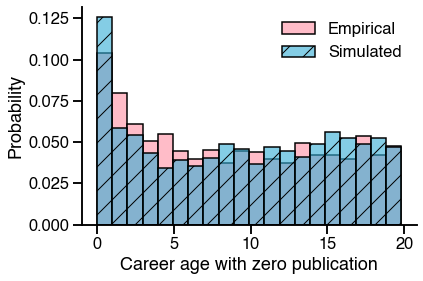

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

df_trajs = trajectories_to_dataframe(trajectories_reg_mle)

df_trajs['pubs_adj_round'] = df_trajs.pubs_adj.round()
sns.histplot(df_prod_survivors[(df_prod_survivors['pubs_adj_round'] == 0) & (df_prod_survivors.CareerAgeZero < 20)].CareerAgeZero, ax=ax, label="Empirical", stat="probability", color=lighter_colors[0], binwidth=0.99, alpha=0.8)
sns.histplot(df_trajs[df_trajs['pubs_adj_round'] == 0].CareerAgeZero, ax=ax, label="Simulated", stat="probability", color=lighter_colors[1], binwidth=0.99, alpha=0.6, hatch='/')
ax.set_xlabel("Career age with zero publication")
ax.legend(frameon=False)

sns.despine()

In [1421]:
ci_emp[0] * 0.679

0.0954082353040064

In [1423]:
trajectories_reg_mle_more.shape[1]

10000

In [1420]:
ci_emp, ci_sim

((0.14051286495435403, 0.15435130319952264),
 (0.08492492803940409, 0.08736159118589064))

In [1413]:
p_emp

0.14743208407693834

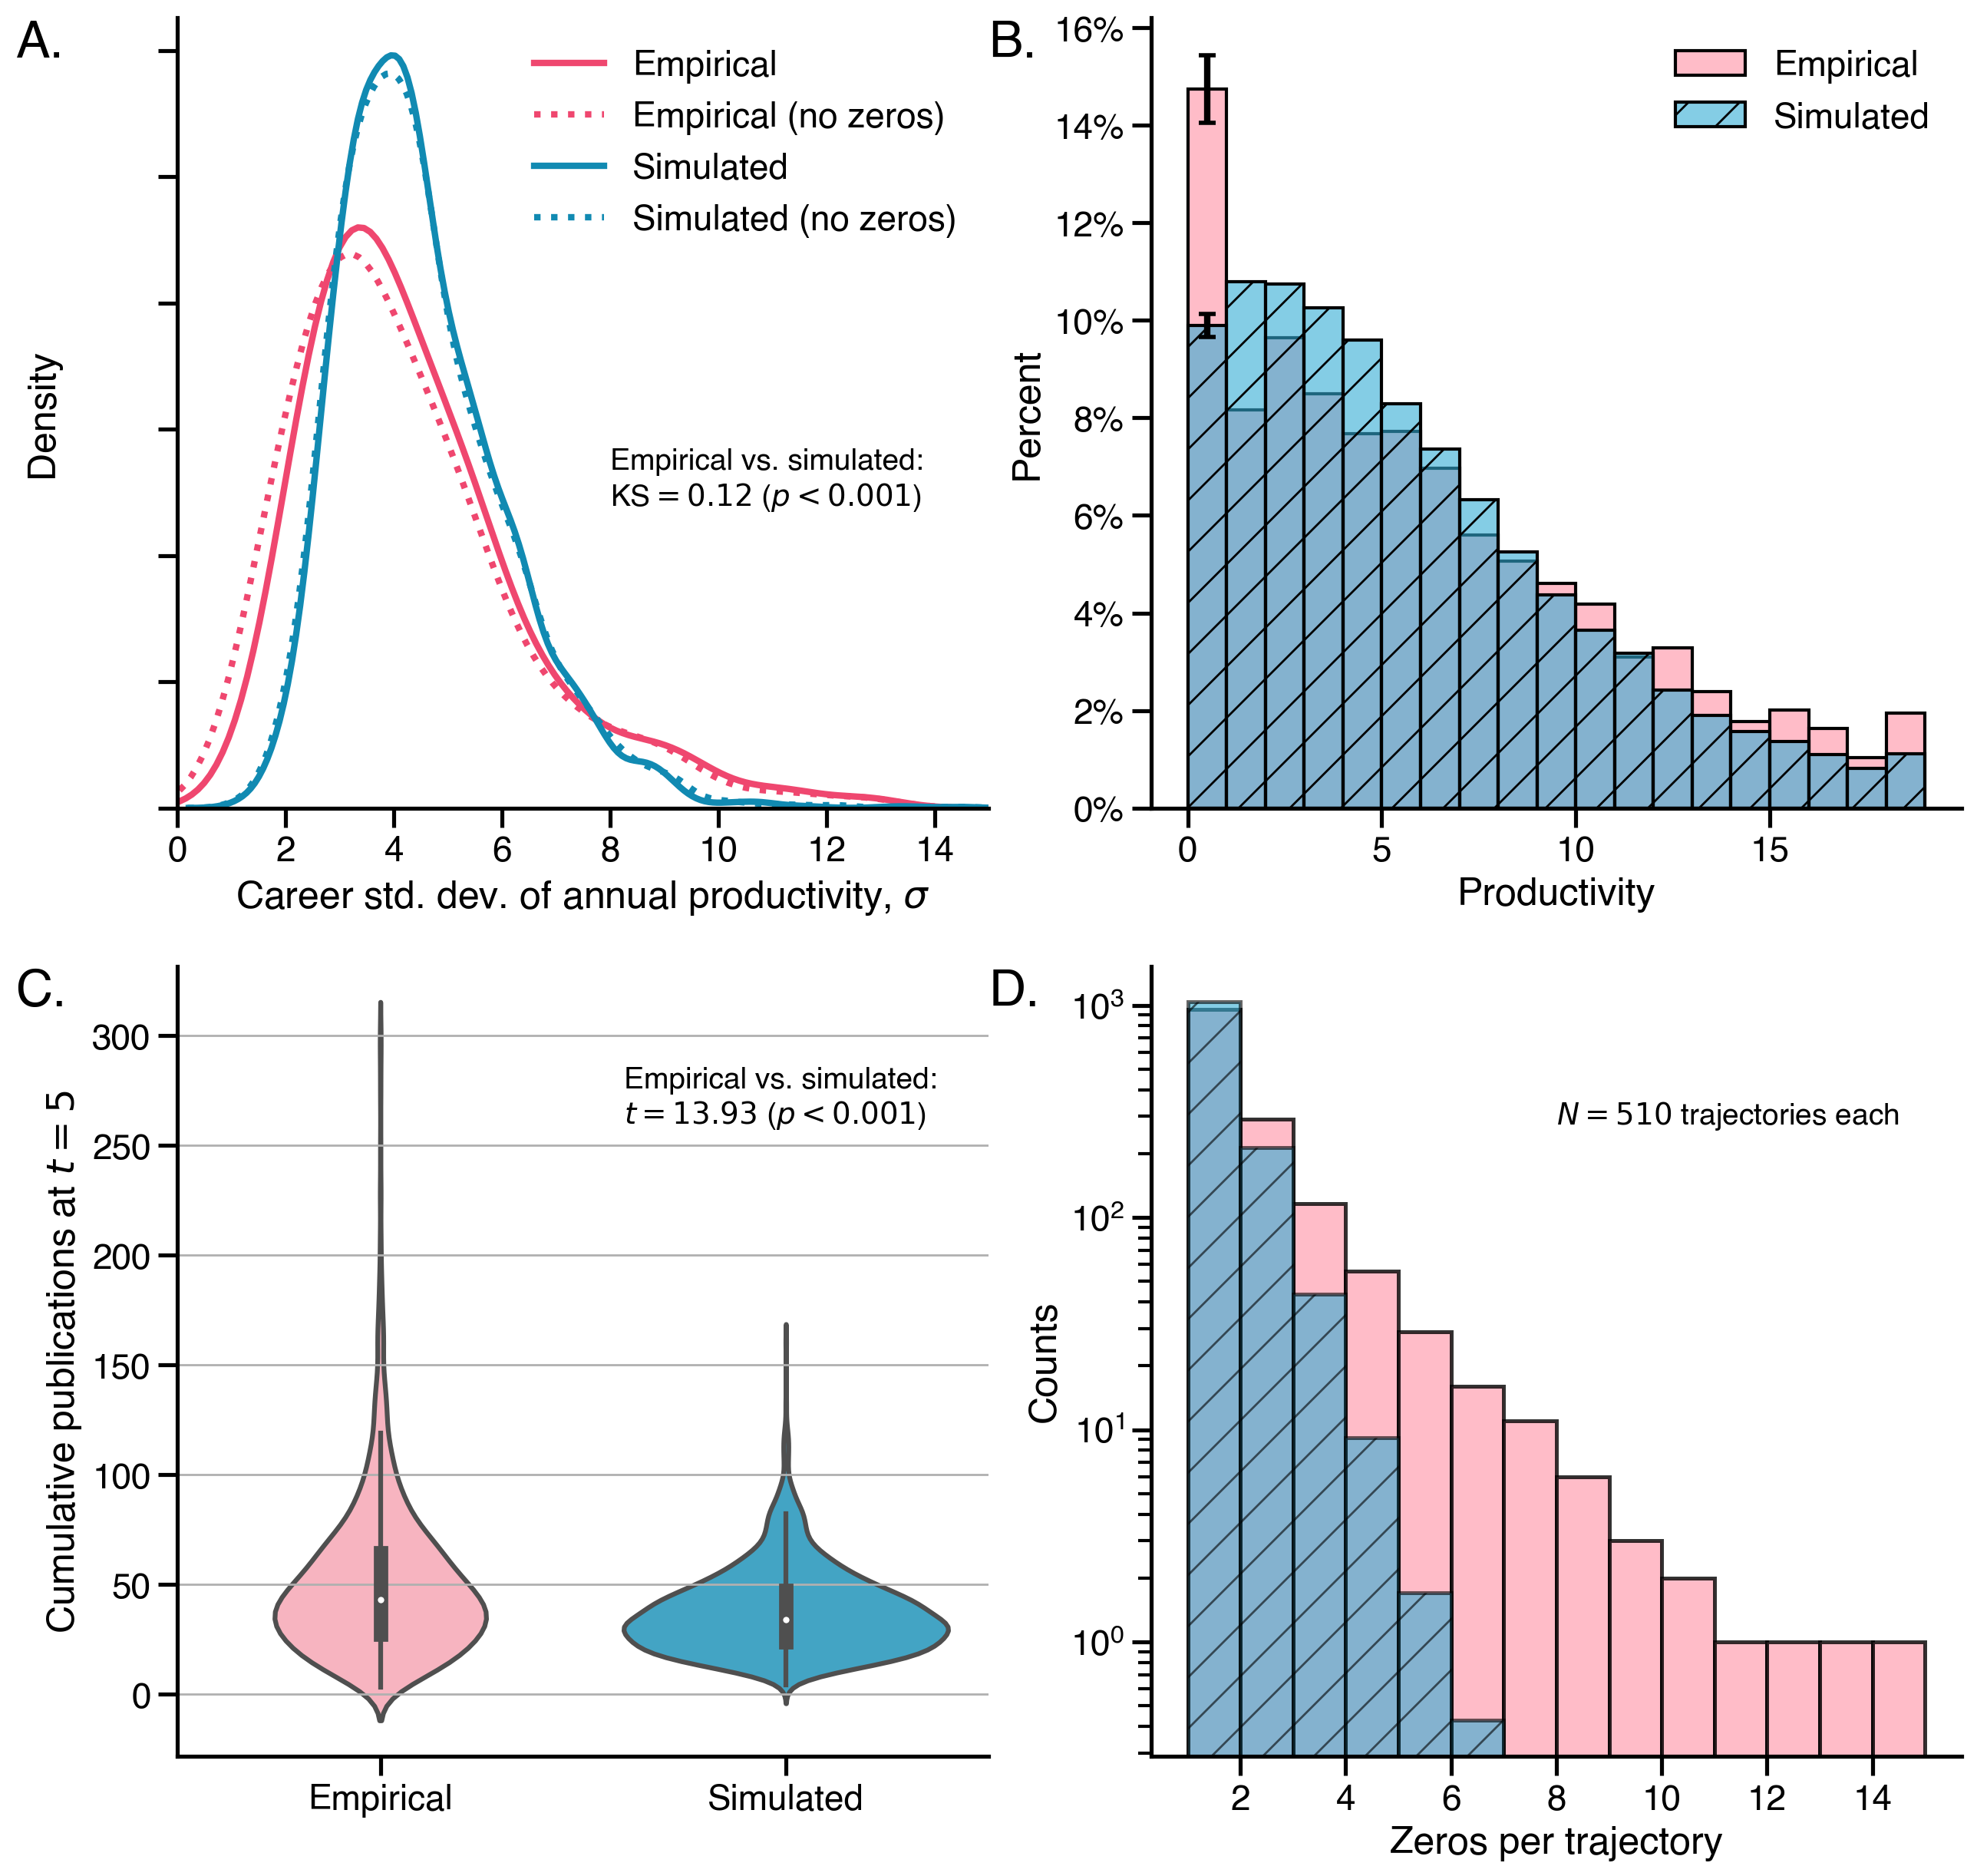

In [1301]:
diagnostic_figures_2b(trajectories_reg_mle_fixed)

Changepoint analysis of simulated vs. empirical

Fit twenty models:
1. Piecewise linear model for each possible change point $t^*$ in years $1$ through $19$.
2. OLS

Pick the best model using AIC.

In [1377]:
def aicc(mod_result):
    return sm.tools.eval_measures.aicc(mod_result.llf, mod_result.nobs, mod_result.df_model)


def fit_linear(traj):
    model_linear = sm.OLS(
        traj,
        sm.add_constant(range(len(traj))),
    )

    results_linear = model_linear.fit()
    return aicc(results_linear)


def fit_piecewise_linear(traj, t, verbose=False):
    traj_before_t = traj[:t]
    traj_after_t = traj[t:]

    model_breakpoint_before_t = sm.OLS(
        traj_before_t,
        sm.add_constant(range(len(traj_before_t))),
    )

    results_breakpoint_before_t = model_breakpoint_before_t.fit()

    model_breakpoint_after_t = sm.OLS(
        traj_after_t,
        sm.add_constant(range(len(traj_after_t))),
    )

    results_breakpoint_after_t = model_breakpoint_after_t.fit()

    #breakpoint_aic = -2*(results_breakpoint_after_t.llf + results_breakpoint_before_t.llf) + 8
    breakpoint_aicc = sm.tools.eval_measures.aicc(results_breakpoint_after_t.llf + results_breakpoint_before_t.llf, len(traj), 4)
    if verbose:
        print(f"Before SSE:{results_breakpoint_before_t.mse_total}*{results_breakpoint_before_t.nobs}, After MSE: {results_breakpoint_after_t.mse_total}*{results_breakpoint_after_t.nobs}")
    
    return breakpoint_aicc, results_breakpoint_before_t.params[1], results_breakpoint_after_t.params[1]


def find_breakpoint(traj):
    traj = traj[:20]
    linear_aicc = fit_linear(traj)
    best_aicc = linear_aicc
    best_params = [None, None]
    best_tstar = -1
    
    for t in range(3, len(traj) - 3):
        current_aicc, m1, m2 = fit_piecewise_linear(traj, t)
        if current_aicc < best_aicc:
            best_aicc = current_aicc
            best_params = (m1, m2)
            best_tstar = t
    
    return best_tstar, best_params[0], best_params[1]

In [1378]:
m1_vs_m2_empirical = []
num_canonical = 0

survivor_breakpoints = df_prod_survivors.groupby('dblp_id').pubs_adj.apply(find_breakpoint)
for tstar, m1, m2 in survivor_breakpoints.values:
    if tstar == -1:
        continue
    
    m1_vs_m2_empirical.append((m1, m2))
    num_canonical += (m1 > 0 and m2 < 0 and m1 > -2*m2)

m1_vs_m2_empirical = np.array(m1_vs_m2_empirical)
num_canonical / len(m1_vs_m2_empirical)

/Users/shzh8108/research/clauset/faculty-hiring-misc/venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


0.2255125284738041

In [1365]:
sim_breakpoints = df_traj_reg_mle.groupby('ix').pubs_adj.apply(find_breakpoint)

In [1366]:
m1_vs_m2_sim = []
num_canonical_sim = 0

for tstar, m1, m2 in sim_breakpoints.values:
    if tstar == -1:
        continue
    
    m1_vs_m2_sim.append((m1, m2))
    num_canonical_sim += (m1 > 0 and m2 < 0 and m1 > -2*m2)

m1_vs_m2_sim = np.array(m1_vs_m2_sim)
num_canonical_sim / len(m1_vs_m2_sim)

0.16507936507936508

In [1381]:
ks_test_breakpoints = st.ks_2samp(
    [x[0] for x in survivor_breakpoints.values if x[0] != -1],
    [x[0] for x in sim_breakpoints.values if x[0] != -1]
)

ks_test_breakpoints

KstestResult(statistic=0.09438960600691808, pvalue=0.0021146346979969977)

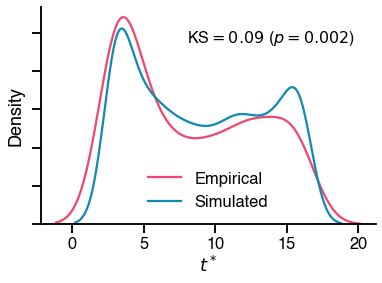

In [1396]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.kdeplot([x[0] for x in survivor_breakpoints.values if x[0] != -1], label='Empirical', ax=ax)
sns.kdeplot([x[0] for x in sim_breakpoints.values if x[0] != -1], label='Simulated', ax=ax)
ax.legend(frameon=False, loc='lower center')
ax.set_xlabel("$t^*$")
ax.yaxis.set_ticklabels([])
ax.text(8, 0.095, f"KS$={ks_test_breakpoints.statistic:.2f}$ (${print_pval(ks_test_breakpoints.pvalue)}$)", fontsize=16)

sns.despine()

In [1401]:
print(f"""Proportion of careers with better fit by nonlinear vs. linear model:
Empirical: {len(m1_vs_m2_empirical) / df_prod_survivors.dblp_id.nunique():.2f}
Simulation: {len(m1_vs_m2_sim) / df_traj_reg_mle.ix.nunique():.2f}""")

Proportion of careers with better fit by nonlinear vs. linear model:
Empirical: 0.86
Simulation: 0.94


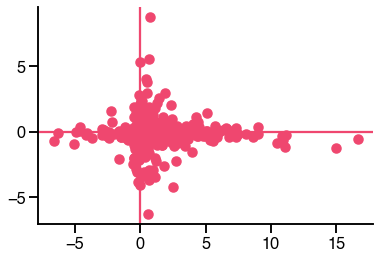

In [1344]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(m1_vs_m2_empirical[:,0], m1_vs_m2_empirical[:,1])

#ax.semilogx()
#ax.semilogy()
ax.axhline(0)
ax.axvline(0)
sns.despine()

In [1329]:
survivor_breakpoints.values

array([(4, -2.1777675478845278, 0.7729709635227084),
       (5, 2.2290538649039924, -0.1249040102390412),
       (4, 4.234040414400079, 0.04294635815981325),
       (6, 2.39477395499064, 0.9749013526221266),
       (3, 6.645381869936208, 0.24852087059211359), (-1, None, None),
       (4, -0.09808468650039714, -0.551318899116817),
       (16, 0.290751413591003, 1.3999634431034162),
       (13, 0.6581778636439143, -0.0019560829054331985),
       (14, 0.3877550340669101, -1.9396006676734285),
       (3, 2.2739597604633746, -0.3361271450359059), (-1, None, None),
       (-1, None, None), (4, 2.179021237351569, -0.04870741791018848),
       (11, -0.2505929422192089, -0.33308502451312894),
       (9, -0.18900335421413092, -0.1897718049835137),
       (9, 0.6702836515978685, -0.054806589819875615),
       (3, 2.4423154551750983, -0.22730178958575506),
       (5, 1.4164069747162815, -0.011076471035412355), (-1, None, None),
       (15, 0.9516513418473332, -2.887365883706747),
       (4, 3.5584

Manual check

In [1036]:
# Looked up some people by hand for years with zero pubs
manual_check = [{'dblp_id': 'DiMarco:Chrysanne1990.0', 'dblp_zeros': 11, 'website_zeros': 5},
 {'dblp_id': 'Heliotis:James_E=1984.0', 'dblp_zeros': 18, 'website_zeros': 14},
 {'dblp_id': 'Brown:Marcus1988.0', 'dblp_zeros': 13, 'website_zeros': 12},
 {'dblp_id': 'Howell:Rodney_R=1988.0', 'dblp_zeros': 14, 'website_zeros': 14},
 {'dblp_id': 'Dringus:Laurie_P=1991.0', 'dblp_zeros': 15, 'website_zeros': 14},
 {'dblp_id': 'Dringus:Laurie_P=1991.0', 'dblp_zeros': 15, 'website_zeros': 15},
 {'dblp_id': 'Watson:Daniel_W=1993.0', 'dblp_zeros': 12, 'website_zeros': 5},
 {'dblp_id': 'Liefvoort:Appie_van_de1982.0', 'dblp_zeros': 10, 'website_zeros': 3}
]

In [1037]:
sum([x['dblp_zeros'] for x in manual_check]), sum([x['website_zeros'] for x in manual_check])

(108, 82)

In [1408]:
np.sqrt((82/108)*(1 - (82/108))*108)

4.443055338473823

In [1409]:
(82 + (1.96*4.44)) / 108, (82 - (1.96*4.44)) / 108

(0.839837037037037, 0.6786814814814816)

In [1410]:
(82/108)

0.7592592592592593

<AxesSubplot:xlabel='dblp_zeros', ylabel='website_zeros'>

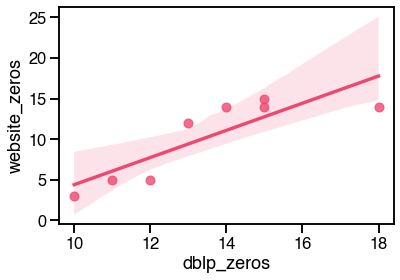

In [1040]:
sns.regplot(data=pd.DataFrame(manual_check), x='dblp_zeros', y='website_zeros')